In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install tensorflow

In [2]:
main_path = r'.'
data_path = main_path+'/data'
import sys
sys.path.append(main_path)
from BayDS.lib.pipeline import *
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union
from BayDS.lib.io import *
from BayDS.lib.training import *
from BayDS.lib.selection import *

import os
import pickle
import gc


import numpy
import pandas as pd

import scipy
from scipy.linalg import norm
from tqdm import tqdm
import dask.dataframe as dd

In [3]:
from BayDS.lib.pipeline.aggregate_nodes import AddGlobalNumericalAggregatesNode, AddGlobalFrequencyEncodingNode,AddGroupFrequencyEncodingNode

## Process raw data

In [4]:
p = Pipeline(working_folder=f'{main_path}/Snapshots/Rating')
p.add_node(LoaderNode, None, 'train',
           params={
               'input_directory': data_path,
               'file': 'onetwotrip_challenge_train.csv'
           })
p.add_node(LoaderNode, None, 'test',
           params={
               'input_directory': data_path,
               'file': 'onetwotrip_challenge_test.csv'
           })
p.run()


---------------------------
0: LoaderNode [2020-01-07 22:44:42]
params:
 {'input_directory': './data', 'file': 'onetwotrip_challenge_train.csv'}
---------------------------
1: LoaderNode [2020-01-07 22:44:43]
params:
 {'input_directory': './data', 'file': 'onetwotrip_challenge_test.csv'}


In [5]:
def mix_train_test(dfs):
    df_train, df_test = dfs
    df_train['orderid'] = df_train['orderid'] + 1000000
    df_train = df_train.set_index('orderid')
    df_test = df_test.set_index('orderid')
    data = pd.concat([df_train, df_test], axis=0, sort=False )
    data.fillna(-1,inplace=True)
    return data

p.add_node(FunctionNode, ('train','test'),'data',
           params={
               'function': mix_train_test
           })
p.run()

---------------------------
2: FunctionNode [2020-01-07 22:44:45]
params:
 {'function': <function mix_train_test at 0x00000265DC8632F0>}


In [6]:
p.add_node(EraserNode, params={
    'remove_keys': ['train', 'test']
})
p.run()

---------------------------
3: EraserNode [2020-01-07 22:44:46]
params:
 {'remove_keys': ['train', 'test']}


In [7]:
p.add_node(ReduceMemoryUsageNode, 'data','data',
               params={
                   'verbose': True
               })
p.run()

---------------------------
4: ReduceMemoryUsageNode [2020-01-07 22:44:47]
params:
 {'verbose': True}
Column userid: object -> object, na_count=0, n_uniq=378449
Column field0: int64 -> int16, na_count=0, n_uniq=503
Column field1: float64 -> float32, na_count=0, n_uniq=317
Column field2: int64 -> int8, na_count=0, n_uniq=12
Column field3: int64 -> int8, na_count=0, n_uniq=12
Column field4: int64 -> int16, na_count=0, n_uniq=756
Column field5: int64 -> int8, na_count=0, n_uniq=2
Column field6: int64 -> int16, na_count=0, n_uniq=212
Column field7: int64 -> int8, na_count=0, n_uniq=2
Column field8: int64 -> int8, na_count=0, n_uniq=2
Column field9: int64 -> int8, na_count=0, n_uniq=5
Column field10: int64 -> int8, na_count=0, n_uniq=2
Column field11: int64 -> int8, na_count=0, n_uniq=24
Column field12: int64 -> int16, na_count=0, n_uniq=316
Column field13: int64 -> int16, na_count=0, n_uniq=929
Column field14: float64 -> float32, na_count=0, n_uniq=199
Column field15: int64 -> int8, na_cou

In [8]:
def set_categorical_features(df):
    cat_fields = ['field12', 'field26', 'field27', 'field29','userid']
    for f in cat_fields:
        df[f] = pd.Categorical(df[f])
    return df

p.add_node(FunctionNode, 'data','data',
           params={
               'function': set_categorical_features
           })
p.run()


---------------------------
5: FunctionNode [2020-01-07 22:44:52]
params:
 {'function': <function set_categorical_features at 0x0000026589570BF8>}


### Features

In [11]:
### Add binarized features as categorical
p.data['data']['price1'] =(p.data['data']['field1'] / 0.077571 + 0.076571896011859 + 11).astype(int)
p.data['data']['price2'] = (p.data['data']['field14'] / 0.140066 + 6.721411648347225).astype(int)

num_to_cat=[f'field{q}' for q in [0,6,13,16,17,22,25]] + ['price1', 'price2']
for f in num_to_cat:
    qcut_data = pd.qcut(p.data['data'][f],10, retbins=True, duplicates='drop',precision=3)[0]
    qcut_data = qcut_data.replace({c:i for i,c in enumerate(qcut_data.dtypes.categories)}).astype(np.uint8)
    p.data['data'][f'{f}bin'] = pd.Categorical(qcut_data)
num_bin_features = [f'{f}bin' for f in num_to_cat]


In [10]:
# p.data['data']['order_till_hour'] = p.data['data']['field21'].astype(str)+'_'+p.data['data']['field2'].astype(str)+'_'+p.data['data']['field18'].astype(str)+'_'+p.data['data']['field11'].astype(str)
# p.data['data']['order_till_weekday'] = p.data['data']['field21'].astype(str)+'_'+p.data['data']['field2'].astype(str)+'_'+p.data['data']['field18'].astype(str)
# p.data['data']['order_till_month'] = p.data['data']['field21'].astype(str)+'_'+p.data['data']['field2'].astype(str)
# p.data['data']['lang_country'] = p.data['data']['field27'].astype(str)+'_'+p.data['data']['field12'].astype(str)
# new_cat_features = ['order_till_hour', 'order_till_weekday','order_till_month', 'lang_country']

# LE=LabelEncoderPopularity()

# for newcat in new_cat_features:
#     LE.fit(p.data['data'][newcat])
#     d = LE.transform(p.data['data'][newcat])
#     p.data['data'][newcat] = pd.Categorical(d)


In [12]:
 p.data['data']['userid'] = pd.Categorical(p.data['data']['userid'])

In [ ]:
p.data['data'].to_pickle('./FE/initial_data.pkl')

## Pre-processing


In [4]:
p = Pipeline(working_folder=f'{main_path}/Snapshots/CorrectedPipeline')
p.add_node(LoaderNode, None, 'data',
           params={
               'input_directory': './FE',
               'file': 'initial_data.pkl'
           })
p.run()



---------------------------
0: LoaderNode [2020-01-18 15:38:10]
params:
 {'input_directory': './FE', 'file': 'initial_data.pkl'}


### Remove empty categories


In [5]:
data = p.data['data']


In [6]:
train = data[data.goal1>=0]
test = data[data.goal1<0]
for f in ('field12','field26','field27','field29'):
    tv = train[f].value_counts()
    absent_in_train = list(tv.index[np.where(tv==0)])
    sv = test[f].value_counts()
    absent_in_test = list(sv.index[np.where(sv==0)])
    absent = absent_in_test+absent_in_train
    col = data[f]
    col.cat = col.cat.add_categories(-1)
    data[f] = pd.Categorical(col.replace({a:-1 for a in absent}))
    print (f'{f}: removed {len(absent)} categories')


field12: removed 67 categories
field26: removed 2 categories
field27: removed 0 categories
field29: removed 0 categories


In [7]:
del train,test
gc.collect()

0

### add top categories from Anna

In [9]:
good = ['field12_global_count',
        'field16_to_mean_groupby_userid', 
        'field16_to_stdscore_groupby_(userid+field29+field22bin)',
        'field4_to_stdscore_groupby_(userid+field21+field22bin)',
        'field16_to_stdscore_groupby_field5',
        'field4_to_stdscore_groupby_(userid+field29+field22bin)',
        'field16_to_stdscore_groupby_(userid+field21+field22bin)',
        'field16_to_stdscore_groupby_(userid+field29)',
        'field4_to_stdscore_groupby_(userid+field29+field13bin)',
        'field16_to_stdscore_groupby_(field10+field6bin+field22bin)',
        'field21_to_stdscore_groupby_(userid+field22bin)', 
        'field4_to_stdscore_groupby_(userid+field21+field13bin)'       
       ]
bigdata = dd.read_parquet('./FE2/BEST3155+Orig.pqt')

In [10]:
for i,gf in enumerate(good):
    feature_name = f'good{i}'
    print (f'{feature_name} is {gf}')
    feat = bigdata[gf].compute()
    qcut_data = pd.qcut(feat,10, retbins=True, duplicates='drop',precision=3)[0]
    qcut_data = qcut_data.replace({c:i for i,c in enumerate(qcut_data.dtypes.categories)}).astype(np.uint8)
    p.data['data'][feature_name] = pd.Categorical(qcut_data)


good0 is field12_global_count
good1 is field16_to_mean_groupby_userid
good2 is field16_to_stdscore_groupby_(userid+field29+field22bin)
good3 is field4_to_stdscore_groupby_(userid+field21+field22bin)
good4 is field16_to_stdscore_groupby_field5
good5 is field4_to_stdscore_groupby_(userid+field29+field22bin)
good6 is field16_to_stdscore_groupby_(userid+field21+field22bin)
good7 is field16_to_stdscore_groupby_(userid+field29)
good8 is field4_to_stdscore_groupby_(userid+field29+field13bin)
good9 is field16_to_stdscore_groupby_(field10+field6bin+field22bin)
good10 is field21_to_stdscore_groupby_(userid+field22bin)
good11 is field4_to_stdscore_groupby_(userid+field21+field13bin)


In [11]:
del bigdata
gc.collect()

0

### Unite rare categories

In [12]:
min_group_size = 5000
for col in ('field12','field26'):
    print (data[col].value_counts().iloc[-1])
    gb_value_counts = pd.DataFrame(data[col].value_counts().sort_values())
    gb_map = {}
    new_category = None
    new_count = 0
    for old_value, count in gb_value_counts.iterrows():
        if count.values[0] > min_group_size and new_category is None:
            gb_map[old_value] = old_value
        else:
            if new_category is None:
                new_category = old_value 
                new_count = count.values[0]
                gb_map[old_value] = new_category
            else:
                new_count += count.values[0]
                gb_map[old_value] = new_category
                if new_count > min_group_size:
                    new_category = None
    data[col+'Merged'] = pd.Categorical(data[col].replace(gb_map))
        

2
4


### Futhrer

In [13]:
gb_features = []
num_features = []

for col in p.data['data'].columns:
    if col.startswith('goal') or col.startswith('indicator_'):
        continue
        
    print (col, p.data['data'][col].dtype.name)
    if p.data['data'][col].dtype.name == 'category' or len(p.data['data'][col].value_counts()) <= 2:
        gb_features.append(col)
    if p.data['data'][col].dtype.name != 'category':
        num_features.append(col)
        
gb_features.remove('field12')
gb_features.remove('field26')

userid category
field0 int16
field1 float32
field2 int8
field3 int8
field4 int16
field5 int8
field6 int16
field7 int8
field8 int8
field9 int8
field10 int8
field11 int8
field12 category
field13 int16
field14 float32
field15 int8
field16 int16
field17 int16
field18 int8
field19 int8
field20 int8
field21 int8
field22 int16
field23 int8
field24 int8
field25 int16
field26 category
field27 category
field28 int8
field29 category
price1 int32
price2 int32
field0bin category
field6bin category
field13bin category
field16bin category
field17bin category
field22bin category
field25bin category
price1bin category
price2bin category
good0 category
good1 category
good2 category
good3 category
good4 category
good5 category
good6 category
good7 category
good8 category
good9 category
good10 category
good11 category
field12Merged category
field26Merged category


In [14]:
C=None
gc.collect()
C = CorrelatorCPU(p.data['data'][num_features],size=5000)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:04<00:00,  6.40it/s]


In [15]:
# rating={}
corr_threshold = 0.9
min_gini = 2

In [16]:
train_idx = p.data['data'][p.data['data']['goal1'] >= 0].index
goal1 = p.data['data'].loc[train_idx,'goal1']

In [17]:
for gb in gb_features:
    print(f'******\n Starting {gb}')
    p.add_node(AddGroupNumericalAggregatesNode, 'data',f'agg_{gb}',
               params={
                   'features': [f for f in num_features if f != gb], 
                   'group_by': [gb],
                   'to_mean': True,
                   'to_std_score': True,
                   'to_std': False,
                   'to_minmax': False
               })
    p.run() 
    
    d = p.data[f'agg_{gb}']
    d_train = d.loc[train_idx]
    for col in d.columns:
        corr = C.get_max_corr(d[col])
        if corr < corr_threshold:
            score = individual_gini(col,d_train,goal1,-1)
            if score < min_gini:
                print('-')
                continue
            C.add_vector(d[col])
            print(col,corr,score)
        else:
            print('.')            
    
    p.add_node(EraserNode, None,None,
           params={
               'remove_keys': [f'agg_{gb}']
           })
    p.run()
    gc.collect()
    

******
 Starting userid
---------------------------
1: AddGroupNumericalAggregatesNode [2020-01-12 15:59:03]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False}
Grouping by 378449 groups, smallest is 1 
field0_to_mean_groupby_userid 0.7332699 10.0
field0_to_stdscore_groupby_userid 0.7472338 7.5
field1_to_mean_groupby_userid 0.013201043 3.3000000000000003
field1_to_stdscore_groupby_userid 0.28216612 4.3
.
field2_to_stdscore_groupby_userid 0.20526007 4.8
.
field3_to_stdscore_groupby_userid 0.80329275 4.5
.
field4_to_stdscore_groupby_userid 0.44476783 10.100000000000001
field5_to_mean_groupby_userid 0.51453704 8.3
field5_to_std

Grouping by 2 groups, smallest is 147617 
field0_to_mean_groupby_field21 0.53836066 6.9
field0_to_stdscore_groupby_field21 0.89943665 7.000000000000001
field1_to_mean_groupby_field21 0.8336495 15.9
.
.
field2_to_stdscore_groupby_field21 0.8997704 8.6
.
.
field4_to_mean_groupby_field21 0.73514503 7.1
.
.
field5_to_stdscore_groupby_field21 0.79426056 6.4
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_field21 0.4062516 16.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
12: EraserNode [2020-01-12 16:02:34]
params:
 {'remove_keys': ['agg_field21']}
******
 Starting field27
---------------------------
13: AddGroupNumericalAggregatesNode [2020-01-12 16:02:34]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28',

Grouping by 8 groups, smallest is 43981 
.
.
field1_to_mean_groupby_field22bin 0.43551278 10.299999999999999
field1_to_stdscore_groupby_field22bin 0.87649095 12.5
.
.
.
.
.
.
.
.
field6_to_mean_groupby_field22bin 0.85893315 8.6
.
.
field7_to_stdscore_groupby_field22bin 0.88959765 17.5
.
.
.
.
.
.
.
.
field13_to_mean_groupby_field22bin 0.89246505 12.1
.
field14_to_mean_groupby_field22bin 0.30305043 12.3
field14_to_stdscore_groupby_field22bin 0.8606292 13.5
.
.
.
.
.
field17_to_stdscore_groupby_field22bin 0.8557667 15.7
.
.
.
.
.
.
.
.
.
field22_to_stdscore_groupby_field22bin 0.5211138 12.4
.
.
.
.
field25_to_mean_groupby_field22bin 0.797981 14.6
field25_to_stdscore_groupby_field22bin 0.6492011 14.7
.
.
.
.
.
.
---------------------------
28: EraserNode [2020-01-12 16:06:34]
params:
 {'remove_keys': ['agg_field22bin']}
******
 Starting field25bin
---------------------------
29: AddGroupNumericalAggregatesNode [2020-01-12 16:06:34]
params:
 {'features': ['field0', 'field1', 'field2', 'fie

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
40: EraserNode [2020-01-12 16:09:35]
params:
 {'remove_keys': ['agg_good2']}
******
 Starting good3
---------------------------
41: AddGroupNumericalAggregatesNode [2020-01-12 16:09:35]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good3'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False}
Grouping by 4 groups, smallest is 24820 
.
.
field1_to_mean_groupby_good3 0.7993755 15.9
.
.
.
.
.
field4_to_mean_groupby_good3 0.6953686 10.100000000000001
.
field5_to_mean_groupby_good3 0.59421724 7.8
field5_to_stdscore_groupby_good3 0.8415138 10.299999999999999
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_good3 0.82735735

Grouping by 4 groups, smallest is 29062 
.
.
field1_to_mean_groupby_good11 0.8766065 14.099999999999998
.
.
.
.
.
field4_to_mean_groupby_good11 0.86987764 10.2
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_good11 0.87323076 15.5
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
58: EraserNode [2020-01-12 16:14:00]
params:
 {'remove_keys': ['agg_good11']}
******
 Starting field12Merged
---------------------------
59: AddGroupNumericalAggregatesNode [2020-01-12 16:14:01]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field12Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False}
Grouping by 26 groups, smallest is 5072 
.
.
field1

In [21]:
correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)                
correlator_data.to_parquet(f'./FE3/Corr_features_{len(correlator_data.columns)}.pqt')   

## Second order group rating

In [22]:
ultimate_features = gb_features

In [23]:
for i1,uf in enumerate(gb_features):
    for i2,gb in enumerate(gb_features):
        if i2<=i1:
            continue
            
        if 'userid' in (uf,gb):
            unite_rare_groups=False
        else:
            unite_rare_groups=True
            
        print(f'******\n Starting {uf}+{gb}')
        p.add_node(AddGroupNumericalAggregatesNode, 'data',f'agg_{uf}_{gb}',
                   params={
                       'features': [f for f in num_features if f not in (uf,gb)], 
                       'group_by': [uf,gb],
                       'to_mean': True,
                       'to_std_score': True,
                       'to_std': False,
                       'to_minmax': False,
                       'unite_rare_groups':unite_rare_groups
                   })
        p.run()    
        d = p.data[f'agg_{uf}_{gb}']
        d_train = d.loc[train_idx]
        for col in d.columns:
            corr = C.get_max_corr(d[col])
            if corr < corr_threshold:
                score = individual_gini(col,d_train,goal1,-1)
                if score < min_gini:
                    print('-')
                    continue
                print(col,corr,score)
                C.add_vector(d[col])
            else:
                print('.')
        p.add_node(EraserNode, None,None,
               params={
                   'remove_keys': [f'agg_{uf}_{gb}']
               })
        p.run()
        gc.collect()
    correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)                
    correlator_data.to_parquet(f'./FE3/Corr_features_{len(correlator_data.columns)}.pqt')                 


******
 Starting userid+field5
---------------------------
63: AddGroupNumericalAggregatesNode [2020-01-12 16:15:52]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 490890 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field5) 0.78636265 3.3000000000000003
field1_to_mean_groupby_(userid+field5) 0.073427975 2.3
field1_to_stdscore_groupby_(userid+field5) 0.75154054 2.9000000000000004
.
field2_to_stdscore_groupby_(userid+field5) 0.7736829 2.9000000000000004
.
field3_to_stdscore_groupby_(userid+field5) 0.83099484 3.6999999999999997
.
field4_to_stdscore_groupby_(userid+fiel

.
field25_to_stdscore_groupby_(userid+field21) 0.8591412 3.5999999999999996
-
-
.
.
.
.
---------------------------
72: EraserNode [2020-01-12 16:20:22]
params:
 {'remove_keys': ['agg_userid_field21']}
******
 Starting userid+field27
---------------------------
73: AddGroupNumericalAggregatesNode [2020-01-12 16:20:22]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field27'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 411897 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field27) 0.6266044 4.0
.
.
.
.
.
.
field4_to_stdscore_groupby_(userid+field27) 0.89970267 7.3999999999999995
field5_to_mean_groupby_(userid+fiel

.
field11_to_stdscore_groupby_(userid+field13bin) 0.74216074 2.9000000000000004
.
-
-
field14_to_stdscore_groupby_(userid+field13bin) 0.7635164 2.8000000000000003
.
-
.
field16_to_stdscore_groupby_(userid+field13bin) 0.76022947 12.8
.
-
.
field18_to_stdscore_groupby_(userid+field13bin) 0.7881618 2.1999999999999997
.
-
.
field20_to_stdscore_groupby_(userid+field13bin) 0.7735111 3.0
.
field21_to_stdscore_groupby_(userid+field13bin) 0.83999395 5.8999999999999995
-
-
.
-
.
field24_to_stdscore_groupby_(userid+field13bin) 0.8187164 2.3
.
field25_to_stdscore_groupby_(userid+field13bin) 0.73310804 2.4
-
-
.
.
.
.
---------------------------
82: EraserNode [2020-01-12 16:25:18]
params:
 {'remove_keys': ['agg_userid_field13bin']}
******
 Starting userid+field16bin
---------------------------
83: AddGroupNumericalAggregatesNode [2020-01-12 16:25:18]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'fie

.
-
.
-
.
-
.
field25_to_stdscore_groupby_(userid+price1bin) 0.58048964 3.2
-
-
.
.
.
.
---------------------------
92: EraserNode [2020-01-12 16:30:12]
params:
 {'remove_keys': ['agg_userid_price1bin']}
******
 Starting userid+price2bin
---------------------------
93: AddGroupNumericalAggregatesNode [2020-01-12 16:30:12]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'price2bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 523545 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+price2bin) 0.6957889 3.1
field1_to_mean_groupby_(userid+price2bin) 0.19404587 2.0
-
.
field2_to_stdscore_groupby_(userid+price2bin) 0.61

field6_to_mean_groupby_(userid+good3) 0.848417 9.0
field6_to_stdscore_groupby_(userid+good3) 0.7964209 4.1000000000000005
.
field7_to_stdscore_groupby_(userid+good3) 0.86235803 2.9000000000000004
.
field8_to_stdscore_groupby_(userid+good3) 0.82766473 2.1
-
-
.
field10_to_stdscore_groupby_(userid+good3) 0.81329304 2.8000000000000003
.
field11_to_stdscore_groupby_(userid+good3) 0.78527 5.2
.
field13_to_stdscore_groupby_(userid+good3) 0.822803 4.9
field14_to_mean_groupby_(userid+good3) 0.098030925 4.2
field14_to_stdscore_groupby_(userid+good3) 0.7841856 5.1
.
field15_to_stdscore_groupby_(userid+good3) 0.79161435 2.3
.
field16_to_stdscore_groupby_(userid+good3) 0.77207446 11.4
.
-
.
field18_to_stdscore_groupby_(userid+good3) 0.79304457 4.5
.
-
.
field20_to_stdscore_groupby_(userid+good3) 0.8032219 5.1
.
field21_to_stdscore_groupby_(userid+good3) 0.87345326 5.5
.
field22_to_stdscore_groupby_(userid+good3) 0.8480274 5.8999999999999995
.
field23_to_stdscore_groupby_(userid+good3) 0.808174 4.7

.
-
-
-
.
field10_to_stdscore_groupby_(userid+good7) 0.7639434 3.2
.
field11_to_stdscore_groupby_(userid+good7) 0.7493243 2.5
.
field13_to_stdscore_groupby_(userid+good7) 0.6995167 3.1
-
field14_to_stdscore_groupby_(userid+good7) 0.7165809 3.5999999999999996
.
-
.
field16_to_stdscore_groupby_(userid+good7) 0.5876139 7.5
.
-
.
field18_to_stdscore_groupby_(userid+good7) 0.7588218 3.6999999999999997
.
-
.
field20_to_stdscore_groupby_(userid+good7) 0.72073555 4.0
.
field21_to_stdscore_groupby_(userid+good7) 0.79213774 4.8
.
field22_to_stdscore_groupby_(userid+good7) 0.7006122 2.9000000000000004
.
field23_to_stdscore_groupby_(userid+good7) 0.71202314 3.5999999999999996
.
-
.
field25_to_stdscore_groupby_(userid+good7) 0.73749006 2.5
-
-
.
.
.
.
---------------------------
110: EraserNode [2020-01-12 16:39:36]
params:
 {'remove_keys': ['agg_userid_good7']}
******
 Starting userid+good8
---------------------------
111: AddGroupNumericalAggregatesNode [2020-01-12 16:39:36]
params:
 {'features':

.
field18_to_stdscore_groupby_(userid+good11) 0.8280229 3.5000000000000004
.
-
.
field20_to_stdscore_groupby_(userid+good11) 0.8286625 4.5
.
field21_to_stdscore_groupby_(userid+good11) 0.89272106 4.8
.
field22_to_stdscore_groupby_(userid+good11) 0.82107127 4.6
.
field23_to_stdscore_groupby_(userid+good11) 0.82716286 3.8
.
.
.
field25_to_stdscore_groupby_(userid+good11) 0.8230217 3.3000000000000003
-
-
.
.
.
.
---------------------------
118: EraserNode [2020-01-12 16:43:55]
params:
 {'remove_keys': ['agg_userid_good11']}
******
 Starting userid+field12Merged
---------------------------
119: AddGroupNumericalAggregatesNode [2020-01-12 16:43:55]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'fiel

Grouping by 7 groups, smallest is 54450 
.
.
field1_to_mean_groupby_(field5+field29|Merge<10000) 0.19521959 10.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field21_to_stdscore_groupby_(field5+field29|Merge<10000) 0.82866436 7.3999999999999995
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
134: EraserNode [2020-01-12 16:48:45]
params:
 {'remove_keys': ['agg_field5_field29']}
******
 Starting field5+field0bin
---------------------------
135: AddGroupNumericalAggregatesNode [2020-01-12 16:48:45]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field5', 'field0bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 5 

Grouping by 18 groups, smallest is 18754 
.
.
field1_to_mean_groupby_(field5+price2bin|Merge<10000) 0.24709095 10.4
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
152: EraserNode [2020-01-12 16:52:59]
params:
 {'remove_keys': ['agg_field5_price2bin']}
******
 Starting field5+good0
---------------------------
153: AddGroupNumericalAggregatesNode [2020-01-12 16:52:59]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field5', 'good0'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 16 groups, smallest is 24193 
.
.
field1_to_mean_groupby_(field5+good0|Merge<10000) 0.5077

Grouping by 6 groups, smallest is 19670 
.
.
field1_to_mean_groupby_(field5+good8|Merge<10000) 0.7659117 16.900000000000002
.
.
.
.
.
.
field4_to_stdscore_groupby_(field5+good8|Merge<10000) 0.88207823 10.7
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field5+good8|Merge<10000) 0.7223298 15.9
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
170: EraserNode [2020-01-12 16:57:38]
params:
 {'remove_keys': ['agg_field5_good8']}
******
 Starting field5+good9
---------------------------
171: AddGroupNumericalAggregatesNode [2020-01-12 16:57:38]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field5', 'good9'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': 

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
186: EraserNode [2020-01-12 17:01:48]
params:
 {'remove_keys': ['agg_field7_field21']}
******
 Starting field7+field27
---------------------------
187: AddGroupNumericalAggregatesNode [2020-01-12 17:01:48]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field7', 'field27'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 8 groups, smallest is 10997 
.
.
field1_to_mean_groupby_(field7+field27|Merge<10000) 0.8091977 13.600000000000001
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field7+field27|Merge<

.
.
.
.
field25_to_mean_groupby_(field7+field22bin|Merge<10000) 0.88100636 14.6
field25_to_stdscore_groupby_(field7+field22bin|Merge<10000) 0.6743329 14.799999999999999
.
.
.
.
.
.
---------------------------
202: EraserNode [2020-01-12 17:05:42]
params:
 {'remove_keys': ['agg_field7_field22bin']}
******
 Starting field7+field25bin
---------------------------
203: AddGroupNumericalAggregatesNode [2020-01-12 17:05:42]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field7', 'field25bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 4 groups, smallest is 47419 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field17_to_mean_groupby_(fi

Grouping by 6 groups, smallest is 16792 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
220: EraserNode [2020-01-12 17:10:16]
params:
 {'remove_keys': ['agg_field7_good5']}
******
 Starting field7+good6
---------------------------
221: AddGroupNumericalAggregatesNode [2020-01-12 17:10:16]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field7', 'good6'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 6 groups, smallest is 16798 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
--------------------------

Grouping by 4 groups, smallest is 37263 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
238: EraserNode [2020-01-12 17:14:58]
params:
 {'remove_keys': ['agg_field8_field10']}
******
 Starting field8+field21
---------------------------
239: AddGroupNumericalAggregatesNode [2020-01-12 17:14:58]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field8', 'field21'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 4 groups, smallest is 18830 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
240: Eraser

Grouping by 13 groups, smallest is 11921 
.
.
field1_to_mean_groupby_(field8+field22bin|Merge<10000) 0.50433594 11.200000000000001
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field8+field22bin|Merge<10000) 0.6398504 11.3
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field25_to_stdscore_groupby_(field8+field22bin|Merge<10000) 0.7556595 14.7
.
.
.
.
.
.
---------------------------
256: EraserNode [2020-01-12 17:19:07]
params:
 {'remove_keys': ['agg_field8_field22bin']}
******
 Starting field8+field25bin
---------------------------
257: AddGroupNumericalAggregatesNode [2020-01-12 17:19:07]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field8', 'field25bin'], 'to_mean': True, 'to_std_score': True

.
.
.
.
.
field6_to_stdscore_groupby_(field8+good4|Merge<10000) 0.89420354 24.7
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
272: EraserNode [2020-01-12 17:22:52]
params:
 {'remove_keys': ['agg_field8_good4']}
******
 Starting field8+good5
---------------------------
273: AddGroupNumericalAggregatesNode [2020-01-12 17:22:52]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field8', 'good5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 5 groups, smallest is 12324 
.
.
field1_to_mean_groupby_(field8+good5|Merge<10000) 0.89321345 15.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_

Grouping by 13 groups, smallest is 10818 
.
.
field1_to_mean_groupby_(field8+field26Merged|Merge<10000) 0.17901433 10.2
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field8+field26Merged|Merge<10000) 0.4324164 11.4
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
290: EraserNode [2020-01-12 17:27:19]
params:
 {'remove_keys': ['agg_field8_field26Merged']}
******
 Starting field10+field21
---------------------------
291: AddGroupNumericalAggregatesNode [2020-01-12 17:27:37]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field10', 'field21'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 4 groups, smalle

Grouping by 16 groups, smallest is 16670 
.
.
field1_to_mean_groupby_(field10+field22bin|Merge<10000) 0.8185108 10.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
field14_to_mean_groupby_(field10+field22bin|Merge<10000) 0.4579366 11.600000000000001
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
308: EraserNode [2020-01-12 17:31:54]
params:
 {'remove_keys': ['agg_field10_field22bin']}
******
 Starting field10+field25bin
---------------------------
309: AddGroupNumericalAggregatesNode [2020-01-12 17:31:54]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field10', 'field25bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grou

Grouping by 6 groups, smallest is 29062 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
field14_to_mean_groupby_(field10+good5|Merge<10000) 0.83049273 16.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
326: EraserNode [2020-01-12 17:36:07]
params:
 {'remove_keys': ['agg_field10_good5']}
******
 Starting field10+good6
---------------------------
327: AddGroupNumericalAggregatesNode [2020-01-12 17:36:07]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field10', 'good6'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 6 groups, smallest is 30316 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
field14_to_mean_gr

Grouping by 8 groups, smallest is 10522 
.
.
.
.
.
.
.
.
field4_to_mean_groupby_(field21+field27|Merge<10000) 0.89636034 8.5
field4_to_stdscore_groupby_(field21+field27|Merge<10000) 0.8554064 8.7
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
344: EraserNode [2020-01-12 17:40:53]
params:
 {'remove_keys': ['agg_field21_field27']}
******
 Starting field21+field29
---------------------------
345: AddGroupNumericalAggregatesNode [2020-01-12 17:40:53]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field21', 'field29'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 6 groups, smallest i

.
---------------------------
360: EraserNode [2020-01-12 17:44:51]
params:
 {'remove_keys': ['agg_field21_field25bin']}
******
 Starting field21+price1bin
---------------------------
361: AddGroupNumericalAggregatesNode [2020-01-12 17:44:51]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field21', 'price1bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 19 groups, smallest is 12859 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
---------------------------
362: EraserNode [2020-01-12 17:45:21]
params:
 {'remove_keys': ['agg_field21_price1bin']}
******
 Starting field21+price2bin
----

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
376: EraserNode [2020-01-12 17:48:44]
params:
 {'remove_keys': ['agg_field21_good5']}
******
 Starting field21+good6
---------------------------
377: AddGroupNumericalAggregatesNode [2020-01-12 17:48:44]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field21', 'good6'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 6 groups, smallest is 27597 
.
.
field1_to_mean_groupby_(field21+good6|Merge<10000) 0.7902916 15.1
.
.
.
.
.
field4_to_mean_groupby_(field21+good6|Merge<10000) 0.8776364 11.700000000000001
.
field5_to_mean_groupby_(field21+good6|Merge<10000) 0.60026646 10.5


Grouping by 14 groups, smallest is 10291 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field21+field26Merged|Merge<10000) 0.8910481 11.3
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
392: EraserNode [2020-01-12 17:52:31]
params:
 {'remove_keys': ['agg_field21_field26Merged']}
******
 Starting field27+field29
---------------------------
393: AddGroupNumericalAggregatesNode [2020-01-12 17:52:50]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field27', 'field29'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 12 groups, smallest is 10967 
.
.
field1_to_mean_groupby_(field2

Grouping by 10 groups, smallest is 10032 
.
.
field1_to_mean_groupby_(field27+field25bin|Merge<10000) 0.18950301 12.9
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field27+field25bin|Merge<10000) 0.5524719 12.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
408: EraserNode [2020-01-12 17:56:49]
params:
 {'remove_keys': ['agg_field27_field25bin']}
******
 Starting field27+price1bin
---------------------------
409: AddGroupNumericalAggregatesNode [2020-01-12 17:56:49]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field27', 'price1bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grou

Grouping by 11 groups, smallest is 10167 
.
.
field1_to_mean_groupby_(field27+good5|Merge<10000) 0.8158367 14.299999999999999
.
.
.
.
.
field4_to_mean_groupby_(field27+good5|Merge<10000) 0.87892425 11.899999999999999
field4_to_stdscore_groupby_(field27+good5|Merge<10000) 0.8627727 11.799999999999999
.
field5_to_stdscore_groupby_(field27+good5|Merge<10000) 0.87700796 11.4
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field27+good5|Merge<10000) 0.3202051 15.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
424: EraserNode [2020-01-12 18:01:03]
params:
 {'remove_keys': ['agg_field27_good5']}
******
 Starting field27+good6
---------------------------
425: AddGroupNumericalAggregatesNode [2020-01-12 18:01:03]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21

Grouping by 10 groups, smallest is 10095 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
440: EraserNode [2020-01-12 18:05:18]
params:
 {'remove_keys': ['agg_field27_field26Merged']}
******
 Starting field29+field0bin
---------------------------
441: AddGroupNumericalAggregatesNode [2020-01-12 18:05:39]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field29', 'field0bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 15 groups, smallest is 10404 
.
.
field1_to_mean_groupby_(field29+field0bin|Merge<10000) 0.23123619 9.9
.
.
.
.
.
.
.
.
.
.
.
.
.

Grouping by 30 groups, smallest is 11222 
.
.
field1_to_mean_groupby_(field29+price2bin|Merge<10000) 0.19571455 9.5
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field29+price2bin|Merge<10000) 0.88531756 12.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
458: EraserNode [2020-01-12 18:10:13]
params:
 {'remove_keys': ['agg_field29_price2bin']}
******
 Starting field29+good0
---------------------------
459: AddGroupNumericalAggregatesNode [2020-01-12 18:10:13]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field29', 'good0'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 28 

Grouping by 13 groups, smallest is 10958 
.
.
field1_to_mean_groupby_(field29+good7|Merge<10000) 0.65756273 13.4
.
.
.
.
.
field4_to_mean_groupby_(field29+good7|Merge<10000) 0.884961 13.100000000000001
.
.
field5_to_stdscore_groupby_(field29+good7|Merge<10000) 0.8517199 14.299999999999999
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field29+good7|Merge<10000) 0.49618796 15.2
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
474: EraserNode [2020-01-12 18:14:10]
params:
 {'remove_keys': ['agg_field29_good7']}
******
 Starting field29+good8
---------------------------
475: AddGroupNumericalAggregatesNode [2020-01-12 18:14:10]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'gro

Grouping by 18 groups, smallest is 11299 
.
.
field1_to_mean_groupby_(field0bin+field13bin|Merge<10000) 0.37764275 8.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field0bin+field13bin|Merge<10000) 0.8565688 11.4
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
490: EraserNode [2020-01-12 18:18:31]
params:
 {'remove_keys': ['agg_field0bin_field13bin']}
******
 Starting field0bin+field16bin
---------------------------
491: AddGroupNumericalAggregatesNode [2020-01-12 18:18:31]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field0bin', 'field16bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups':

Grouping by 22 groups, smallest is 10037 
field0_to_mean_groupby_(field0bin+good1|Merge<10000) 0.50878364 7.3
field0_to_stdscore_groupby_(field0bin+good1|Merge<10000) 0.8059995 13.3
field1_to_mean_groupby_(field0bin+good1|Merge<10000) 0.7952373 15.5
.
.
.
.
.
.
field4_to_stdscore_groupby_(field0bin+good1|Merge<10000) 0.87282085 13.700000000000001
.
field5_to_stdscore_groupby_(field0bin+good1|Merge<10000) 0.86302495 15.1
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field0bin+good1|Merge<10000) 0.6685316 17.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field21_to_stdscore_groupby_(field0bin+good1|Merge<10000) 0.8438895 16.900000000000002
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
506: EraserNode [2020-01-12 18:22:27]
params:
 {'remove_keys': ['agg_field0bin_good1']}
******
 Starting field0bin+good2
---------------------------
507: AddGroupNumericalAggregatesNode [2020-01-12 18:22:27]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7

Grouping by 11 groups, smallest is 11060 
field0_to_mean_groupby_(field0bin+good8|Merge<10000) 0.82490903 7.3
field0_to_stdscore_groupby_(field0bin+good8|Merge<10000) 0.86194795 8.799999999999999
field1_to_mean_groupby_(field0bin+good8|Merge<10000) 0.8183564 13.700000000000001
.
.
.
.
.
.
field4_to_stdscore_groupby_(field0bin+good8|Merge<10000) 0.8911984 10.4
.
field5_to_stdscore_groupby_(field0bin+good8|Merge<10000) 0.8500667 10.100000000000001
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field0bin+good8|Merge<10000) 0.76360834 15.7
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field21_to_stdscore_groupby_(field0bin+good8|Merge<10000) 0.8831547 10.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
520: EraserNode [2020-01-12 18:25:59]
params:
 {'remove_keys': ['agg_field0bin_good8']}
******
 Starting field0bin+good9
---------------------------
521: AddGroupNumericalAggregatesNode [2020-01-12 18:25:59]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'fie

Grouping by 17 groups, smallest is 11730 
.
.
field1_to_mean_groupby_(field6bin+field16bin|Merge<10000) 0.76525605 21.9
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field16_to_stdscore_groupby_(field6bin+field16bin|Merge<10000) 0.89163506 25.0
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
534: EraserNode [2020-01-12 18:30:08]
params:
 {'remove_keys': ['agg_field6bin_field16bin']}
******
 Starting field6bin+field17bin
---------------------------
535: AddGroupNumericalAggregatesNode [2020-01-12 18:30:08]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field6bin', 'field17bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_gr

.
.
.
.
.
---------------------------
548: EraserNode [2020-01-12 18:33:52]
params:
 {'remove_keys': ['agg_field6bin_good1']}
******
 Starting field6bin+good2
---------------------------
549: AddGroupNumericalAggregatesNode [2020-01-12 18:33:52]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field6bin', 'good2'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 4 groups, smallest is 55234 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
550: EraserNode [2020-01-12 18:34:23]
params:
 {'remove_keys': ['agg_field6bin_good2']}
******
 Starting field6bin

Grouping by 8 groups, smallest is 13025 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
568: EraserNode [2020-01-12 18:38:42]
params:
 {'remove_keys': ['agg_field6bin_good11']}
******
 Starting field6bin+field12Merged
---------------------------
569: AddGroupNumericalAggregatesNode [2020-01-12 18:38:42]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field6bin', 'field12Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 26 groups, smallest is 10143 
.
.
field1_to_mean_groupby_(field6bin+field12Merged|Merge<10000) 0.7394112 13.100000000000001

Grouping by 37 groups, smallest is 10117 
.
.
field1_to_mean_groupby_(field13bin+price1bin|Merge<10000) 0.14124206 12.0
field1_to_stdscore_groupby_(field13bin+price1bin|Merge<10000) 0.58595634 14.799999999999999
.
.
.
.
.
.
.
.
field6_to_mean_groupby_(field13bin+price1bin|Merge<10000) 0.801355 8.5
.
.
.
.
.
.
.
.
.
.
.
field13_to_mean_groupby_(field13bin+price1bin|Merge<10000) 0.87719536 11.799999999999999
field13_to_stdscore_groupby_(field13bin+price1bin|Merge<10000) 0.7245073 11.899999999999999
field14_to_mean_groupby_(field13bin+price1bin|Merge<10000) 0.34225765 9.1
field14_to_stdscore_groupby_(field13bin+price1bin|Merge<10000) 0.8324319 11.3
.
.
.
.
field17_to_mean_groupby_(field13bin+price1bin|Merge<10000) 0.88978887 14.399999999999999
.
.
.
.
.
.
.
.
.
.
field22_to_stdscore_groupby_(field13bin+price1bin|Merge<10000) 0.89954716 10.2
.
.
.
.
.
field25_to_stdscore_groupby_(field13bin+price1bin|Merge<10000) 0.8730272 15.8
-
.
price1_to_mean_groupby_(field13bin+price1bin|Merge<10000) 

Grouping by 14 groups, smallest is 12773 
.
.
field1_to_mean_groupby_(field13bin+good5|Merge<10000) 0.83244795 12.4
.
.
.
.
.
.
.
field5_to_mean_groupby_(field13bin+good5|Merge<10000) 0.6640121 9.6
.
.
.
.
.
.
.
.
.
.
.
.
.
field13_to_mean_groupby_(field13bin+good5|Merge<10000) 0.87430835 10.0
field13_to_stdscore_groupby_(field13bin+good5|Merge<10000) 0.8998637 10.6
field14_to_mean_groupby_(field13bin+good5|Merge<10000) 0.4913969 14.000000000000002
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
596: EraserNode [2020-01-12 18:46:38]
params:
 {'remove_keys': ['agg_field13bin_good5']}
******
 Starting field13bin+good6
---------------------------
597: AddGroupNumericalAggregatesNode [2020-01-12 18:46:38]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field2

.
.
.
.
field10_to_mean_groupby_(field13bin+field12Merged|Merge<10000) 0.8632459 15.4
field10_to_stdscore_groupby_(field13bin+field12Merged|Merge<10000) 0.8891714 20.8
.
.
field13_to_mean_groupby_(field13bin+field12Merged|Merge<10000) 0.8530541 15.2
field13_to_stdscore_groupby_(field13bin+field12Merged|Merge<10000) 0.738948 17.4
field14_to_mean_groupby_(field13bin+field12Merged|Merge<10000) 0.2946579 10.8
.
.
.
.
.
field17_to_mean_groupby_(field13bin+field12Merged|Merge<10000) 0.8704151 21.3
field17_to_stdscore_groupby_(field13bin+field12Merged|Merge<10000) 0.82014406 20.9
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field25_to_mean_groupby_(field13bin+field12Merged|Merge<10000) 0.8889163 22.2
field25_to_stdscore_groupby_(field13bin+field12Merged|Merge<10000) 0.87829393 21.2
.
.
.
.
.
.
---------------------------
610: EraserNode [2020-01-12 18:50:13]
params:
 {'remove_keys': ['agg_field13bin_field12Merged']}
******
 Starting field13bin+field26Merged
---------------------------
611: AddGroupNumericalAg

.
.
.
.
.
.
.
.
.
field6_to_mean_groupby_(field16bin+price2bin|Merge<10000) 0.86365193 8.799999999999999
field6_to_stdscore_groupby_(field16bin+price2bin|Merge<10000) 0.88681597 23.200000000000003
.
.
.
field8_to_stdscore_groupby_(field16bin+price2bin|Merge<10000) 0.8992186 26.8
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field16bin+price2bin|Merge<10000) 0.1549187 21.6
field14_to_stdscore_groupby_(field16bin+price2bin|Merge<10000) 0.6641155 21.4
.
.
.
field16_to_stdscore_groupby_(field16bin+price2bin|Merge<10000) 0.64833754 21.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
622: EraserNode [2020-01-12 18:54:03]
params:
 {'remove_keys': ['agg_field16bin_price2bin']}
******
 Starting field16bin+good0
---------------------------
623: AddGroupNumericalAggregatesNode [2020-01-12 18:54:03]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15',

Grouping by 17 groups, smallest is 11216 
.
.
field1_to_mean_groupby_(field16bin+good6|Merge<10000) 0.8176369 15.5
.
.
.
.
.
.
field4_to_stdscore_groupby_(field16bin+good6|Merge<10000) 0.8332235 22.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field16bin+good6|Merge<10000) 0.7973003 18.099999999999998
.
.
.
.
field16_to_stdscore_groupby_(field16bin+good6|Merge<10000) 0.89458 22.400000000000002
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
636: EraserNode [2020-01-12 18:57:51]
params:
 {'remove_keys': ['agg_field16bin_good6']}
******
 Starting field16bin+good7
---------------------------
637: AddGroupNumericalAggregatesNode [2020-01-12 18:57:51]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'pric

Grouping by 35 groups, smallest is 10059 
.
.
field1_to_mean_groupby_(field16bin+field26Merged|Merge<10000) 0.32765913 14.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field16bin+field26Merged|Merge<10000) 0.32113227 16.0
.
.
.
.
field16_to_stdscore_groupby_(field16bin+field26Merged|Merge<10000) 0.76069015 19.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
650: EraserNode [2020-01-12 19:01:41]
params:
 {'remove_keys': ['agg_field16bin_field26Merged']}
******
 Starting field17bin+field22bin
---------------------------
651: AddGroupNumericalAggregatesNode [2020-01-12 19:02:07]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field17bin', 'field22bin'],

Grouping by 7 groups, smallest is 11586 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
666: EraserNode [2020-01-12 19:06:05]
params:
 {'remove_keys': ['agg_field17bin_good3']}
******
 Starting field17bin+good4
---------------------------
667: AddGroupNumericalAggregatesNode [2020-01-12 19:06:06]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field17bin', 'good4'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 15 groups, smallest is 10586 
.
.
field1_to_mean_groupby_(field17bin+good4|Merge<10000) 0.2639836 17.7
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


Grouping by 22 groups, smallest is 10483 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field13_to_mean_groupby_(field17bin+field12Merged|Merge<10000) 0.8978776 15.1
field13_to_stdscore_groupby_(field17bin+field12Merged|Merge<10000) 0.88093597 14.799999999999999
field14_to_mean_groupby_(field17bin+field12Merged|Merge<10000) 0.8638345 16.7
.
.
.
.
.
.
field17_to_stdscore_groupby_(field17bin+field12Merged|Merge<10000) 0.8823009 22.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
684: EraserNode [2020-01-12 19:10:27]
params:
 {'remove_keys': ['agg_field17bin_field12Merged']}
******
 Starting field17bin+field26Merged
---------------------------
685: AddGroupNumericalAggregatesNode [2020-01-12 19:10:27]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23',

Grouping by 31 groups, smallest is 10617 
.
.
field1_to_mean_groupby_(field22bin+good1|Merge<10000) 0.3553957 10.6
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field22bin+good1|Merge<10000) 0.6452562 12.3
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field22_to_stdscore_groupby_(field22bin+good1|Merge<10000) 0.7910823 11.700000000000001
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
696: EraserNode [2020-01-12 19:14:05]
params:
 {'remove_keys': ['agg_field22bin_good1']}
******
 Starting field22bin+good2
---------------------------
697: AddGroupNumericalAggregatesNode [2020-01-12 19:14:05]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field22bin', 'good2'], 'to_mean': True, 'to_std_score

Grouping by 42 groups, smallest is 10416 
.
.
field1_to_mean_groupby_(field22bin+good9|Merge<10000) 0.25489232 12.6
.
.
.
.
.
.
.
.
.
field6_to_mean_groupby_(field22bin+good9|Merge<10000) 0.8310665 8.799999999999999
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(field22bin+good9|Merge<10000) 0.5054864 13.5
.
.
.
field16_to_mean_groupby_(field22bin+good9|Merge<10000) 0.84337705 17.599999999999998
field16_to_stdscore_groupby_(field22bin+good9|Merge<10000) 0.7137357 15.9
.
.
.
.
.
.
.
.
.
.
field22_to_mean_groupby_(field22bin+good9|Merge<10000) 0.8885871 15.8
field22_to_stdscore_groupby_(field22bin+good9|Merge<10000) 0.66508055 17.1
.
.
.
.
field25_to_mean_groupby_(field22bin+good9|Merge<10000) 0.8856841 22.3
field25_to_stdscore_groupby_(field22bin+good9|Merge<10000) 0.7919998 21.3
.
.
.
.
.
.
---------------------------
712: EraserNode [2020-01-12 19:18:07]
params:
 {'remove_keys': ['agg_field22bin_good9']}
******
 Starting field22bin+good10
---------------------------
713: AddGroupN

.
.
.
.
.
field17_to_stdscore_groupby_(field25bin+price2bin|Merge<10000) 0.8980739 18.2
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
724: EraserNode [2020-01-12 19:21:54]
params:
 {'remove_keys': ['agg_field25bin_price2bin']}
******
 Starting field25bin+good0
---------------------------
725: AddGroupNumericalAggregatesNode [2020-01-12 19:21:54]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field25bin', 'good0'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 15 groups, smallest is 11325 
.
.
field1_to_mean_groupby_(field25bin+good0|Merge<10000) 0.80216306 14.799999999999999
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


Grouping by 8 groups, smallest is 13089 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
742: EraserNode [2020-01-12 19:26:30]
params:
 {'remove_keys': ['agg_field25bin_good8']}
******
 Starting field25bin+good9
---------------------------
743: AddGroupNumericalAggregatesNode [2020-01-12 19:26:30]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['field25bin', 'good9'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 19 groups, smallest is 10102 
.
.
field1_to_mean_groupby_(field25bin+good9|Merge<10000) 0.3907314 19.400000000000002
.
.
.
.
.
.
.
.
.
.


.
field15_to_stdscore_groupby_(price1bin+good0|Merge<10000) 0.89969116 17.9
.
.
.
field17_to_stdscore_groupby_(price1bin+good0|Merge<10000) 0.8806488 21.2
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
---------------------------
756: EraserNode [2020-01-12 19:30:43]
params:
 {'remove_keys': ['agg_price1bin_good0']}
******
 Starting price1bin+good1
---------------------------
757: AddGroupNumericalAggregatesNode [2020-01-12 19:30:43]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['price1bin', 'good1'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 37 groups, smallest is 10065 
.
.
field1_to_mean_groupby_(price1bin+good1|Merge<10000) 0.67639

field1_to_stdscore_groupby_(price1bin+good7|Merge<10000) 0.82744795 18.3
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(price1bin+good7|Merge<10000) 0.70552087 16.400000000000002
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
---------------------------
770: EraserNode [2020-01-12 19:34:18]
params:
 {'remove_keys': ['agg_price1bin_good7']}
******
 Starting price1bin+good8
---------------------------
771: AddGroupNumericalAggregatesNode [2020-01-12 19:34:18]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['price1bin', 'good8'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 21 groups, smallest is 10406 
.
.


.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
.
.
field14_to_mean_groupby_(price1bin+field26Merged|Merge<10000) 0.3161503 8.1
field14_to_stdscore_groupby_(price1bin+field26Merged|Merge<10000) 0.8201359 11.899999999999999
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
---------------------------
782: EraserNode [2020-01-12 19:37:32]
params:
 {'remove_keys': ['agg_price1bin_field26Merged']}
******
 Starting price2bin+good0
---------------------------
783: AddGroupNumericalAggregatesNode [2020-01-12 19:38:02]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['price2bin', 'good0'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 42 groups, sma

Grouping by 23 groups, smallest is 10805 
.
.
field1_to_mean_groupby_(price2bin+good7|Merge<10000) 0.5234024 13.3
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(price2bin+good7|Merge<10000) 0.38449192 17.1
field14_to_stdscore_groupby_(price2bin+good7|Merge<10000) 0.8279093 17.7
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
798: EraserNode [2020-01-12 19:42:18]
params:
 {'remove_keys': ['agg_price2bin_good7']}
******
 Starting price2bin+good8
---------------------------
799: AddGroupNumericalAggregatesNode [2020-01-12 19:42:18]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['price2bin', 'good8'], 'to_mean': True, 'to_std_score': True, 'to_std': 

Grouping by 35 groups, smallest is 10570 
.
.
field1_to_mean_groupby_(good0+good1|Merge<10000) 0.7055091 11.600000000000001
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(good0+good1|Merge<10000) 0.37199873 15.4
.
.
.
.
field16_to_stdscore_groupby_(good0+good1|Merge<10000) 0.8976226 21.3
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
812: EraserNode [2020-01-12 19:46:50]
params:
 {'remove_keys': ['agg_good0_good1']}
******
 Starting good0+good2
---------------------------
813: AddGroupNumericalAggregatesNode [2020-01-12 19:46:50]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good0', 'good2'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to

Grouping by 49 groups, smallest is 10113 
.
.
field1_to_mean_groupby_(good0+good9|Merge<10000) 0.20568313 10.2
.
.
.
.
.
.
.
.
.
field6_to_mean_groupby_(good0+good9|Merge<10000) 0.873581 8.7
.
.
.
.
.
.
.
field10_to_mean_groupby_(good0+good9|Merge<10000) 0.84521836 15.8
.
.
.
.
.
field14_to_mean_groupby_(good0+good9|Merge<10000) 0.47305214 16.0
.
.
.
field16_to_mean_groupby_(good0+good9|Merge<10000) 0.8746897 20.0
field16_to_stdscore_groupby_(good0+good9|Merge<10000) 0.78131723 18.3
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
828: EraserNode [2020-01-12 19:50:56]
params:
 {'remove_keys': ['agg_good0_good9']}
******
 Starting good0+good10
---------------------------
829: AddGroupNumericalAggregatesNode [2020-01-12 19:50:56]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'f

Grouping by 16 groups, smallest is 10364 
.
.
field1_to_mean_groupby_(good1+good5|Merge<10000) 0.8490917 16.8
.
.
.
.
.
.
field4_to_stdscore_groupby_(good1+good5|Merge<10000) 0.8041499 16.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(good1+good5|Merge<10000) 0.6230131 16.5
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
844: EraserNode [2020-01-12 19:55:26]
params:
 {'remove_keys': ['agg_good1_good5']}
******
 Starting good1+good6
---------------------------
845: AddGroupNumericalAggregatesNode [2020-01-12 19:55:26]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good1', 'good6'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False,

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
858: EraserNode [2020-01-12 19:59:01]
params:
 {'remove_keys': ['agg_good1_field12Merged']}
******
 Starting good1+field26Merged
---------------------------
859: AddGroupNumericalAggregatesNode [2020-01-12 19:59:01]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good1', 'field26Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 28 groups, smallest is 10261 
.
.
field1_to_mean_groupby_(good1+field26Merged|Merge<10000) 0.6095983 11.200000000000001
.
.
.
.
.
field4_to_mean_groupby_(good1+field26Merged|Merge<10000) 0.89049524 12.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.


Grouping by 7 groups, smallest is 12178 
.
.
field1_to_mean_groupby_(good2+good10|Merge<10000) 0.8960754 18.099999999999998
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
876: EraserNode [2020-01-12 20:03:53]
params:
 {'remove_keys': ['agg_good2_good10']}
******
 Starting good2+good11
---------------------------
877: AddGroupNumericalAggregatesNode [2020-01-12 20:03:53]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good2', 'good11'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 7 groups, smallest is 16907 
.
.
.
.
.
.
.
.
.
field4_to_stdscore_groupb

Grouping by 22 groups, smallest is 11266 
.
.
field1_to_mean_groupby_(good3+good9|Merge<10000) 0.37696353 14.7
.
.
.
.
.
.
.
field5_to_mean_groupby_(good3+good9|Merge<10000) 0.81557405 16.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(good3+good9|Merge<10000) 0.6821894 18.099999999999998
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
894: EraserNode [2020-01-12 20:09:05]
params:
 {'remove_keys': ['agg_good3_good9']}
******
 Starting good3+good10
---------------------------
895: AddGroupNumericalAggregatesNode [2020-01-12 20:09:05]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good3', 'good10'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_m

Grouping by 21 groups, smallest is 11173 
.
.
.
.
.
.
.
.
.
.
field5_to_mean_groupby_(good4+good8|Merge<10000) 0.847924 18.5
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(good4+good8|Merge<10000) 0.79038155 19.900000000000002
.
.
.
.
field16_to_stdscore_groupby_(good4+good8|Merge<10000) 0.8688509 22.1
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
910: EraserNode [2020-01-12 20:13:46]
params:
 {'remove_keys': ['agg_good4_good8']}
******
 Starting good4+good9
---------------------------
911: AddGroupNumericalAggregatesNode [2020-01-12 20:13:46]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good4', 'good9'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_

.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(good5+good7|Merge<10000) 0.87905705 16.7
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
924: EraserNode [2020-01-12 20:17:57]
params:
 {'remove_keys': ['agg_good5_good7']}
******
 Starting good5+good8
---------------------------
925: AddGroupNumericalAggregatesNode [2020-01-12 20:17:57]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good5', 'good8'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 8 groups, smallest is 10987 
.
.
.
.
.
.
.
.
.
field4_to_stdscore_groupby_(good5+good8|Merge<10000) 0.86762047 9.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field1

.
.
.
.
.
field4_to_mean_groupby_(good6+good8|Merge<10000) 0.82467824 11.700000000000001
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(good6+good8|Merge<10000) 0.77216387 16.1
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
940: EraserNode [2020-01-12 20:22:28]
params:
 {'remove_keys': ['agg_good6_good8']}
******
 Starting good6+good9
---------------------------
941: AddGroupNumericalAggregatesNode [2020-01-12 20:22:28]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good6', 'good9'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 20 groups, smallest is 10109 
.
.
.
.
.
.
.
.
.
.
.
.
.
.


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(good7+good10|Merge<10000) 0.7855515 18.2
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
956: EraserNode [2020-01-12 20:27:15]
params:
 {'remove_keys': ['agg_good7_good10']}
******
 Starting good7+good11
---------------------------
957: AddGroupNumericalAggregatesNode [2020-01-12 20:27:15]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good7', 'good11'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 13 groups, smallest is 10262 
.
.
field1_to_mean_groupby_(good7+good11|Merge<10000) 0.43157476 15.8
.
.
.
.
.
.
.
field5_to_mean_groupby_(good

Grouping by 17 groups, smallest is 10653 
.
.
field1_to_mean_groupby_(good8+field26Merged|Merge<10000) 0.7154302 10.7
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean_groupby_(good8+field26Merged|Merge<10000) 0.7858739 13.100000000000001
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
972: EraserNode [2020-01-12 20:32:13]
params:
 {'remove_keys': ['agg_good8_field26Merged']}
******
 Starting good9+good10
---------------------------
973: AddGroupNumericalAggregatesNode [2020-01-12 20:32:50]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good9', 'good10'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True

.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
986: EraserNode [2020-01-12 20:37:18]
params:
 {'remove_keys': ['agg_good10_field26Merged']}
******
 Starting good11+field12Merged
---------------------------
987: AddGroupNumericalAggregatesNode [2020-01-12 20:37:56]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['good11', 'field12Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': True}
Grouping by 30 groups, smallest is 10025 
.
.
field1_to_mean_groupby_(good11+field12Merged|Merge<10000) 0.5897572 12.0
.
.
.
.
.
.
field4_to_stdscore_groupby_(good11+field12Merged|Merge<10000) 0.8647101 20.8
field5_to_mean_groupby_(good11+field12Merged|Merge<100

## Third order groups

In [32]:
started=False
for i1,uf1 in enumerate(gb_features):
    for i2,uf2 in enumerate(gb_features):
        for i3,gb in enumerate(gb_features):
            if i2<=i1 or i3<=i2:
                continue
            if 'userid' in (uf1,uf2,gb):
                unite_rare_groups=False
            else:
                unite_rare_groups=True                
            if uf1=='userid' and uf2 == 'good8' and gb =='good10':
                started=True
            if not started:
                continue
            print(f'******\n Starting {uf1}+{uf2}+{gb}')
            p.add_node(AddGroupNumericalAggregatesNode, 'data',f'agg3',
                       params={
                           'features': [f for f in num_features if f not in (uf1,uf2,gb)], 
                           'group_by': [uf1,uf2,gb],
                           'to_mean': True,
                           'to_std_score': True,
                           'to_std': False,
                           'to_minmax': False,
                           'unite_rare_groups':unite_rare_groups
                       })
            p.run()    
            d = p.data[f'agg3']
            d_train = d.loc[train_idx]
            for col in d.columns:
                corr = C.get_max_corr(d[col])
                if corr < corr_threshold:
                    score = individual_gini(col,d_train,goal1,-1)
                    if score < min_gini:
                        print('-')
                        continue
                    print(col,corr,score)
                    C.add_vector(d[col])
                else:
                    print('.')
            p.add_node(EraserNode, None,None,
                   params={
                       'remove_keys': [f'agg3']
                   })
            p.run()
            gc.collect()
#     correlator_data = pd.DataFrame(index=C.index, data=C.gpudata.get()[:,:len(C.names)],columns=C.names)                
    if started:
        correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)                
        correlator_data.to_parquet(f'./FE3/Corr_features_{len(correlator_data.columns)}.pqt')   

******
 Starting userid+field5+good3
---------------------------
1030: AddGroupNumericalAggregatesNode [2020-01-12 23:41:49]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field5', 'good3'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 553103 groups, smallest is 1 
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
-
-
-
.
-
.
.
.
.
.
.
.
-
.
.
.
-
.
.
.
-
.
field20_to_stdscore_groupby_(userid+field5+good3) 0.76284814 2.6
.
field21_to_stdscore_groupby_(userid+field5+good3) 0.85767126 2.6
.
field22_to_stdscore_groupby_(userid+field5+good3) 0.8088853 2.6
.
field23_to_stdscore_groupby_(userid+field5+good3) 0.7642866 2.6
.
-
.
-
-
-
.
.
.
.
------------------

Grouping by 546928 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field5+good8) 0.80295694 3.4000000000000004
field1_to_mean_groupby_(userid+field5+good8) 0.60519993 2.8000000000000003
field1_to_stdscore_groupby_(userid+field5+good8) 0.8063463 3.8
.
field2_to_stdscore_groupby_(userid+field5+good8) 0.8467453 3.8
.
field3_to_stdscore_groupby_(userid+field5+good8) 0.8495152 4.2
.
field4_to_stdscore_groupby_(userid+field5+good8) 0.7935564 3.1
field6_to_mean_groupby_(userid+field5+good8) 0.86872125 8.799999999999999
-
.
-
.
-
-
-
.
field10_to_stdscore_groupby_(userid+field5+good8) 0.8452557 2.1
.
field11_to_stdscore_groupby_(userid+field5+good8) 0.8178647 3.3000000000000003
.
field13_to_stdscore_groupby_(userid+field5+good8) 0.822891 2.9000000000000004
field14_to_mean_groupby_(userid+field5+good8) 0.72599584 3.0
field14_to_stdscore_groupby_(userid+field5+good8) 0.8093106 2.9000000000000004
.
-
.
field16_to_stdscore_groupby_(userid+field5+good8) 0.80134016 6.7
.
-
.
field18_to_s

Grouping by 417127 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field7+field8) 0.89594007 6.5
.
field1_to_stdscore_groupby_(userid+field7+field8) 0.8672032 2.7
.
field2_to_stdscore_groupby_(userid+field7+field8) 0.89375705 5.4
.
field3_to_stdscore_groupby_(userid+field7+field8) 0.8954942 5.5
.
.
.
.
.
.
-
-
.
.
.
.
.
field13_to_stdscore_groupby_(userid+field7+field8) 0.8914374 5.800000000000001
field14_to_mean_groupby_(userid+field7+field8) 0.06352352 3.3000000000000003
-
.
-
.
field16_to_stdscore_groupby_(userid+field7+field8) 0.8888882 15.1
.
.
.
.
.
-
.
.
.
field21_to_stdscore_groupby_(userid+field7+field8) 0.8999172 6.800000000000001
.
field22_to_stdscore_groupby_(userid+field7+field8) 0.8700332 5.6000000000000005
.
.
.
.
.
.
-
-
.
.
.
-
---------------------------
1053: EraserNode [2020-01-12 23:57:29]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field7+field10
---------------------------
1054: AddGroupNumericalAggregatesNode [2020-01-12 23:57:29]
para

Grouping by 481414 groups, smallest is 1 
.
.
-
.
.
.
.
.
.
.
.
.
.
.
.
-
-
-
.
.
.
.
.
-
-
.
.
-
.
.
.
-
.
.
.
-
.
.
.
.
.
-
.
-
.
.
.
field25_to_stdscore_groupby_(userid+field7+field13bin) 0.5889379 2.6
-
-
.
.
.
.
---------------------------
1067: EraserNode [2020-01-13 00:05:07]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field7+field16bin
---------------------------
1068: AddGroupNumericalAggregatesNode [2020-01-13 00:05:07]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field7', 'field16bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 536229 groups, smallest is 1 
.
.
-
.
.
.
.
.
.
.
.
.
.
-
.
-
-
-
.
field10_t

Grouping by 430337 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field7+good2) 0.86627513 7.3
.
field1_to_stdscore_groupby_(userid+field7+good2) 0.86977077 7.1
.
field2_to_stdscore_groupby_(userid+field7+good2) 0.89800525 7.199999999999999
.
field3_to_stdscore_groupby_(userid+field7+good2) 0.89186543 7.7
.
field4_to_stdscore_groupby_(userid+field7+good2) 0.87941223 8.6
.
field5_to_stdscore_groupby_(userid+field7+good2) 0.88520294 7.6
field6_to_mean_groupby_(userid+field7+good2) 0.89337456 9.2
field6_to_stdscore_groupby_(userid+field7+good2) 0.8546618 4.2
.
-
-
-
.
field10_to_stdscore_groupby_(userid+field7+good2) 0.887729 5.8999999999999995
.
.
.
.
field14_to_mean_groupby_(userid+field7+good2) 0.52144974 6.1
field14_to_stdscore_groupby_(userid+field7+good2) 0.85298055 6.3
.
field15_to_stdscore_groupby_(userid+field7+good2) 0.868444 3.1
.
.
.
.
.
.
.
field19_to_stdscore_groupby_(userid+field7+good2) 0.26339477 2.0
.
field20_to_stdscore_groupby_(userid+field7+good2) 0.88378

Grouping by 549566 groups, smallest is 1 
field0_to_mean_groupby_(userid+field7+good9) 0.8990627 7.5
field0_to_stdscore_groupby_(userid+field7+good9) 0.8189403 2.4
-
.
.
.
.
.
.
.
.
-
.
.
.
-
-
-
.
field10_to_stdscore_groupby_(userid+field7+good9) 0.6403839 2.0
.
-
.
-
field14_to_mean_groupby_(userid+field7+good9) 0.19911027 2.6
.
.
-
.
.
.
-
.
field18_to_stdscore_groupby_(userid+field7+good9) 0.66074556 2.0
.
-
.
.
.
field21_to_stdscore_groupby_(userid+field7+good9) 0.6913627 2.6
.
-
.
.
.
-
.
-
-
-
.
.
.
.
---------------------------
1099: EraserNode [2020-01-13 00:20:07]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field7+good10
---------------------------
1100: AddGroupNumericalAggregatesNode [2020-01-13 00:20:07]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'f

Grouping by 490503 groups, smallest is 1 
.
.
.
-
.
.
.
.
.
.
.
.
field6_to_mean_groupby_(userid+field8+field29) 0.84342116 8.5
field6_to_stdscore_groupby_(userid+field8+field29) 0.7250223 2.0
.
.
-
-
.
.
.
-
.
.
-
.
.
-
.
.
.
.
.
-
.
-
.
-
.
-
.
.
.
.
.
-
.
.
-
-
.
-
.
.
---------------------------
1115: EraserNode [2020-01-13 00:27:29]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field8+field0bin
---------------------------
1116: AddGroupNumericalAggregatesNode [2020-01-13 00:27:29]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field8', 'field0bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 526251 groups, smallest

Grouping by 544513 groups, smallest is 1 
.
.
.
.
.
-
.
.
.
.
.
.
field6_to_mean_groupby_(userid+field8+price1bin) 0.8644014 8.5
-
.
-
-
-
.
-
.
-
.
-
-
.
.
-
.
.
.
.
.
-
.
-
.
-
.
.
.
field22_to_stdscore_groupby_(userid+field8+price1bin) 0.70383 2.1
.
-
.
-
.
.
-
-
.
.
.
.
---------------------------
1131: EraserNode [2020-01-13 00:34:56]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field8+price2bin
---------------------------
1132: AddGroupNumericalAggregatesNode [2020-01-13 00:34:56]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field8', 'price2bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 529712 groups, smalle

.
field1_to_mean_groupby_(userid+field8+good6) 0.74211866 7.1
.
.
.
.
.
.
.
.
.
field6_to_mean_groupby_(userid+field8+good6) 0.8964306 8.799999999999999
field6_to_stdscore_groupby_(userid+field8+good6) 0.85659564 2.4
.
field7_to_stdscore_groupby_(userid+field8+good6) 0.8845265 2.1
-
-
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
.
-
.
.
.
field21_to_stdscore_groupby_(userid+field8+good6) 0.8901452 6.5
.
.
.
.
.
field24_to_stdscore_groupby_(userid+field8+good6) 0.8504996 2.1999999999999997
.
field25_to_stdscore_groupby_(userid+field8+good6) 0.8748777 2.1
-
-
.
.
.
.
---------------------------
1147: EraserNode [2020-01-13 00:42:40]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field8+good7
---------------------------
1148: AddGroupNumericalAggregatesNode [2020-01-13 00:42:41]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'f

Grouping by 488501 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field10+field21) 0.85247004 5.5
field1_to_mean_groupby_(userid+field10+field21) 0.19681662 2.4
field1_to_stdscore_groupby_(userid+field10+field21) 0.8452801 2.3
.
field2_to_stdscore_groupby_(userid+field10+field21) 0.8439057 4.8
.
field3_to_stdscore_groupby_(userid+field10+field21) 0.8437844 3.0
.
field4_to_stdscore_groupby_(userid+field10+field21) 0.8544435 6.3
.
field5_to_stdscore_groupby_(userid+field10+field21) 0.859342 4.7
.
field6_to_stdscore_groupby_(userid+field10+field21) 0.86208 3.1
.
field7_to_stdscore_groupby_(userid+field10+field21) 0.862201 2.1
.
-
-
-
.
field11_to_stdscore_groupby_(userid+field10+field21) 0.8640189 2.0
.
field13_to_stdscore_groupby_(userid+field10+field21) 0.8685452 4.5
-
field14_to_stdscore_groupby_(userid+field10+field21) 0.8426725 3.0
.
-
.
field16_to_stdscore_groupby_(userid+field10+field21) 0.847366 12.0
.
field17_to_stdscore_groupby_(userid+field10+field21) 0.8816308 2.4

.
field21_to_stdscore_groupby_(userid+field10+field13bin) 0.8563316 3.6999999999999997
.
-
.
-
.
-
.
-
-
-
.
.
.
-
---------------------------
1173: EraserNode [2020-01-13 00:54:17]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field10+field16bin
---------------------------
1174: AddGroupNumericalAggregatesNode [2020-01-13 00:54:17]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field10', 'field16bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 556449 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field10+field16bin) 0.83836555 2.9000000000000004
-
field1_to_stdscore_groupby_(userid+field10+field16bin) 0.83

Grouping by 506574 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field10+good0) 0.41966805 2.0
field1_to_stdscore_groupby_(userid+field10+good0) 0.74239683 2.5
.
.
.
.
.
field4_to_stdscore_groupby_(userid+field10+good0) 0.8995605 5.8999999999999995
.
.
.
.
.
-
.
-
-
-
.
-
.
.
field14_to_mean_groupby_(userid+field10+good0) 0.07327933 2.1999999999999997
-
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
.
.
.
.
.
.
.
-
-
.
.
.
-
---------------------------
1187: EraserNode [2020-01-13 01:01:26]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field10+good1
---------------------------
1188: AddGroupNumericalAggregatesNode [2020-01-13 01:01:26]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field10', 'good

field14_to_stdscore_groupby_(userid+field10+good5) 0.8162114 3.2
.
-
.
field16_to_stdscore_groupby_(userid+field10+good5) 0.8180498 9.1
.
-
.
field18_to_stdscore_groupby_(userid+field10+good5) 0.84532493 4.1000000000000005
.
-
.
field20_to_stdscore_groupby_(userid+field10+good5) 0.83694166 3.9
.
field21_to_stdscore_groupby_(userid+field10+good5) 0.8404294 3.2
.
field22_to_stdscore_groupby_(userid+field10+good5) 0.8439975 4.6
.
field23_to_stdscore_groupby_(userid+field10+good5) 0.8247829 4.2
.
-
.
field25_to_stdscore_groupby_(userid+field10+good5) 0.8479558 2.4
-
-
.
.
.
.
---------------------------
1197: EraserNode [2020-01-13 01:06:19]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field10+good6
---------------------------
1198: AddGroupNumericalAggregatesNode [2020-01-13 01:06:19]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'fie

Grouping by 490923 groups, smallest is 1 
field0_to_mean_groupby_(userid+field10+good10) 0.8945659 9.9
field0_to_stdscore_groupby_(userid+field10+good10) 0.83353454 5.1
field1_to_mean_groupby_(userid+field10+good10) 0.0341966 2.6
field1_to_stdscore_groupby_(userid+field10+good10) 0.8378405 2.7
.
field2_to_stdscore_groupby_(userid+field10+good10) 0.82569796 4.0
.
field3_to_stdscore_groupby_(userid+field10+good10) 0.82605886 3.5000000000000004
.
field4_to_stdscore_groupby_(userid+field10+good10) 0.8416172 6.7
.
field5_to_stdscore_groupby_(userid+field10+good10) 0.8489671 4.7
.
field6_to_stdscore_groupby_(userid+field10+good10) 0.8380896 4.0
.
field7_to_stdscore_groupby_(userid+field10+good10) 0.83626556 2.0
.
-
-
-
.
field11_to_stdscore_groupby_(userid+field10+good10) 0.85017276 2.6
.
field13_to_stdscore_groupby_(userid+field10+good10) 0.8425145 3.0
field14_to_mean_groupby_(userid+field10+good10) 0.18793939 3.5000000000000004
field14_to_stdscore_groupby_(userid+field10+good10) 0.83404714

Grouping by 496743 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field21+field29) 0.16804819 2.7
field1_to_stdscore_groupby_(userid+field21+field29) 0.80247176 2.5
.
.
.
.
.
field4_to_stdscore_groupby_(userid+field21+field29) 0.8541584 6.6000000000000005
.
field5_to_stdscore_groupby_(userid+field21+field29) 0.886728 5.4
.
.
.
.
.
-
-
-
.
.
.
field11_to_stdscore_groupby_(userid+field21+field29) 0.82079995 2.8000000000000003
.
.
field14_to_mean_groupby_(userid+field21+field29) 0.84396654 2.7
.
.
-
.
.
.
.
.
field18_to_stdscore_groupby_(userid+field21+field29) 0.8160281 2.8000000000000003
.
-
.
-
.
.
.
.
.
-
.
.
-
-
.
.
.
.
---------------------------
1217: EraserNode [2020-01-13 01:16:22]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field21+field0bin
---------------------------
1218: AddGroupNumericalAggregatesNode [2020-01-13 01:16:22]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'fie

.
-
.
-
.
-
-
-
.
-
.
field11_to_stdscore_groupby_(userid+field21+field22bin) 0.8126899 5.0
.
field13_to_stdscore_groupby_(userid+field21+field22bin) 0.47543117 2.1
field14_to_mean_groupby_(userid+field21+field22bin) 0.17498207 3.3000000000000003
field14_to_stdscore_groupby_(userid+field21+field22bin) 0.8054682 3.9
.
-
.
field16_to_stdscore_groupby_(userid+field21+field22bin) 0.79162365 10.5
.
-
.
field18_to_stdscore_groupby_(userid+field21+field22bin) 0.80255044 4.5
.
-
.
field20_to_stdscore_groupby_(userid+field21+field22bin) 0.81274647 2.6
.
-
.
field23_to_stdscore_groupby_(userid+field21+field22bin) 0.64422476 2.1999999999999997
.
-
.
-
-
-
.
.
.
.
---------------------------
1229: EraserNode [2020-01-13 01:21:58]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field21+field25bin
---------------------------
1230: AddGroupNumericalAggregatesNode [2020-01-13 01:21:58]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'fi

field1_to_stdscore_groupby_(userid+field21+good2) 0.8975647 4.5
.
.
.
.
.
.
.
.
.
field6_to_stdscore_groupby_(userid+field21+good2) 0.8957746 3.9
.
.
.
field8_to_stdscore_groupby_(userid+field21+good2) 0.77894115 2.0
-
-
.
field10_to_stdscore_groupby_(userid+field21+good2) 0.8749203 3.5000000000000004
.
field11_to_stdscore_groupby_(userid+field21+good2) 0.89505607 3.5999999999999996
.
.
field14_to_mean_groupby_(userid+field21+good2) 0.07997836 3.2
.
.
field15_to_stdscore_groupby_(userid+field21+good2) 0.79452246 2.0
.
field16_to_stdscore_groupby_(userid+field21+good2) 0.80435795 9.700000000000001
.
.
.
field18_to_stdscore_groupby_(userid+field21+good2) 0.897242 3.6999999999999997
.
-
.
.
.
.
.
field23_to_stdscore_groupby_(userid+field21+good2) 0.8751784 4.6
.
.
.
.
-
-
.
.
.
.
---------------------------
1241: EraserNode [2020-01-13 01:28:11]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field21+good3
---------------------------
1242: AddGroupNumericalAggregatesNode [2020-

-
-
.
.
.
.
---------------------------
1249: EraserNode [2020-01-13 01:32:09]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field21+good7
---------------------------
1250: AddGroupNumericalAggregatesNode [2020-01-13 01:32:09]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field21', 'good7'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 546940 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field21+good7) 0.74325067 2.7
.
-
.
-
.
field3_to_stdscore_groupby_(userid+field21+good7) 0.6832332 2.1999999999999997
.
field4_to_stdscore_groupby_(userid+field21+good7) 0.76447463 3.1
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
-
-
.


.
.
-
-
.
-
.
.
.
-
.
.
.
-
.
-
.
.
.
field23_to_stdscore_groupby_(userid+field21+field12Merged) 0.837353 2.3
.
-
.
-
-
-
.
.
.
-
---------------------------
1261: EraserNode [2020-01-13 01:38:14]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field21+field26Merged
---------------------------
1262: AddGroupNumericalAggregatesNode [2020-01-13 01:38:15]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field21', 'field26Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 474889 groups, smallest is 1 
.
.
.
.
.
field2_to_stdscore_groupby_(userid+field21+field26Merged) 0.89055425 5.1
.
field3_to_stdscore_groupby_(userid+field21

Grouping by 512548 groups, smallest is 1 
.
.
-
-
.
.
.
.
.
.
.
field5_to_stdscore_groupby_(userid+field27+field22bin) 0.8734754 4.0
.
field6_to_stdscore_groupby_(userid+field27+field22bin) 0.72922647 2.1
.
-
.
-
-
-
.
.
.
.
.
-
-
.
.
-
.
.
.
-
.
.
.
-
.
.
.
field21_to_stdscore_groupby_(userid+field27+field22bin) 0.89721763 4.8
.
-
.
-
.
.
.
-
-
-
.
-
.
.
---------------------------
1277: EraserNode [2020-01-13 01:45:49]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field27+field25bin
---------------------------
1278: AddGroupNumericalAggregatesNode [2020-01-13 01:45:49]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field27', 'field25bin'], 'to_mean': True, 'to_std_score': True, '

Grouping by 555884 groups, smallest is 1 
.
.
-
.
.
.
.
.
.
.
.
-
.
-
.
-
.
-
-
-
.
.
.
-
.
-
-
.
.
-
.
.
.
-
.
-
.
-
.
-
.
.
.
-
.
-
.
-
.
.
-
-
.
.
.
.
---------------------------
1293: EraserNode [2020-01-13 01:53:31]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field27+good5
---------------------------
1294: AddGroupNumericalAggregatesNode [2020-01-13 01:53:31]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field27', 'good5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 479810 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field27+good5) 0.50996464 5.8999999999999995
.
.
.
.
.
.
field4_to_stdsco

.
.
.
.
.
-
-
-
.
.
.
.
.
.
field14_to_mean_groupby_(userid+field27+good11) 0.59285516 4.7
.
.
.
.
.
.
.
.
.
.
-
.
.
.
field21_to_stdscore_groupby_(userid+field27+good11) 0.89159423 5.0
.
.
.
.
.
-
.
.
-
-
.
.
.
.
---------------------------
1307: EraserNode [2020-01-13 02:00:15]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field27+field12Merged
---------------------------
1308: AddGroupNumericalAggregatesNode [2020-01-13 02:00:15]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field27', 'field12Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 520536 groups, smallest is 1 
.
field0_to_stdscore_groupby_(us

-
.
-
.
-
-
-
.
-
.
-
.
-
-
-
.
-
.
field16_to_stdscore_groupby_(userid+field29+field16bin) 0.32248294 2.1
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1319: EraserNode [2020-01-13 02:05:57]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field29+field17bin
---------------------------
1320: AddGroupNumericalAggregatesNode [2020-01-13 02:05:57]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field29', 'field17bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 494411 groups, smallest is 1 
.
.
.
-
.
.
.
.
.
.
.
.
.
.
.
-
.
-
-
-
.
.
.
-
.
field13_to_stdscore_groupby_(userid+field29+fie

-
-
.
-
.
field16_to_stdscore_groupby_(userid+field29+good0) 0.77615553 8.200000000000001
.
-
.
field18_to_stdscore_groupby_(userid+field29+good0) 0.7887788 2.1
.
-
.
-
.
-
.
field22_to_stdscore_groupby_(userid+field29+good0) 0.831613 2.1
.
-
.
-
.
field25_to_stdscore_groupby_(userid+field29+good0) 0.81852466 2.0
-
-
.
-
.
-
---------------------------
1331: EraserNode [2020-01-13 02:12:13]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field29+good1
---------------------------
1332: AddGroupNumericalAggregatesNode [2020-01-13 02:12:13]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field29', 'good1'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unit

Grouping by 539146 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field29+good6) 0.7998602 3.2
field1_to_mean_groupby_(userid+field29+good6) 0.66339785 2.1999999999999997
field1_to_stdscore_groupby_(userid+field29+good6) 0.8167558 2.4
.
field2_to_stdscore_groupby_(userid+field29+good6) 0.80292916 2.1
.
field3_to_stdscore_groupby_(userid+field29+good6) 0.80229646 2.1
.
field4_to_stdscore_groupby_(userid+field29+good6) 0.8173784 3.2
.
field5_to_stdscore_groupby_(userid+field29+good6) 0.81711626 2.0
field6_to_mean_groupby_(userid+field29+good6) 0.8895079 8.4
field6_to_stdscore_groupby_(userid+field29+good6) 0.8119195 2.4
.
-
.
-
-
-
.
-
.
-
.
field13_to_stdscore_groupby_(userid+field29+good6) 0.8164207 2.6
field14_to_mean_groupby_(userid+field29+good6) 0.21306342 2.0
field14_to_stdscore_groupby_(userid+field29+good6) 0.81492925 2.6
.
-
.
field16_to_stdscore_groupby_(userid+field29+good6) 0.7358047 5.3
.
-
.
field18_to_stdscore_groupby_(userid+field29+good6) 0.8045474 2.1
.
-


.
-
.
field22_to_stdscore_groupby_(userid+field29+good11) 0.81661195 3.1
.
field23_to_stdscore_groupby_(userid+field29+good11) 0.79727703 2.1999999999999997
.
-
.
field25_to_stdscore_groupby_(userid+field29+good11) 0.8073603 2.1999999999999997
-
-
.
-
.
-
---------------------------
1353: EraserNode [2020-01-13 02:23:50]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field29+field12Merged
---------------------------
1354: AddGroupNumericalAggregatesNode [2020-01-13 02:23:51]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field29', 'field12Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 557270 groups, small

Grouping by 532038 groups, smallest is 1 
.
.
-
-
.
.
.
.
.
.
.
.
.
-
.
-
.
-
-
-
.
.
.
-
.
field13_to_stdscore_groupby_(userid+field0bin+field25bin) 0.8691557 2.1999999999999997
field14_to_mean_groupby_(userid+field0bin+field25bin) 0.1223832 2.0
-
.
-
.
.
.
-
.
.
.
-
.
.
.
.
.
field22_to_stdscore_groupby_(userid+field0bin+field25bin) 0.8678409 2.5
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1369: EraserNode [2020-01-13 02:32:25]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field0bin+price1bin
---------------------------
1370: AddGroupNumericalAggregatesNode [2020-01-13 02:32:26]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field0bin', 'price1bin'], 'to_mean': True, 'to_

-
.
field4_to_stdscore_groupby_(userid+field0bin+good4) 0.6762648 2.0
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1383: EraserNode [2020-01-13 02:40:10]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field0bin+good5
---------------------------
1384: AddGroupNumericalAggregatesNode [2020-01-13 02:40:10]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field0bin', 'good5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 572087 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field0bin+good5) 0.78142357 2.5
field1_to_mean_groupby_(use

.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1395: EraserNode [2020-01-13 02:46:35]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field0bin+good11
---------------------------
1396: AddGroupNumericalAggregatesNode [2020-01-13 02:46:35]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field0bin', 'good11'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 587514 groups, smallest is 1 
.
-
-
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
-
-
.
-
.
field16_to_stdscore_groupby_(userid+field0bin+good11) 0.74858874 4.0
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1

Grouping by 435797 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field6bin+field25bin) 0.72725546 4.3999999999999995
.
.
.
.
.
.
.
.
.
.
-
.
-
.
-
-
-
.
.
.
.
.
.
field14_to_mean_groupby_(userid+field6bin+field25bin) 0.82558906 5.1
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
.
.
.
.
.
.
-
-
-
.
.
.
.
---------------------------
1411: EraserNode [2020-01-13 02:54:19]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field6bin+price1bin
---------------------------
1412: AddGroupNumericalAggregatesNode [2020-01-13 02:54:19]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field6bin', 'price1bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups

field23_to_stdscore_groupby_(userid+field6bin+good4) 0.71398073 2.0
.
-
.
.
-
-
.
.
.
.
---------------------------
1425: EraserNode [2020-01-13 03:01:24]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field6bin+good5
---------------------------
1426: AddGroupNumericalAggregatesNode [2020-01-13 03:01:24]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field6bin', 'good5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 480585 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field6bin+good5) 0.86223584 6.800000000000001
field1_to_stdscore_groupby_(userid+field6bin+good5) 0.885635 6.1
.
.
.
.
.
.
.
.
field6_t

Grouping by 506981 groups, smallest is 1 
.
.
.
field1_to_stdscore_groupby_(userid+field6bin+good11) 0.89438295 5.2
.
.
.
.
.
.
.
.
.
-
.
field7_to_stdscore_groupby_(userid+field6bin+good11) 0.8950044 2.1
.
-
-
-
.
.
.
.
.
.
field14_to_mean_groupby_(userid+field6bin+good11) 0.6393241 5.1
field14_to_stdscore_groupby_(userid+field6bin+good11) 0.89890164 4.7
.
field15_to_stdscore_groupby_(userid+field6bin+good11) 0.86632437 2.1999999999999997
.
.
.
.
.
.
.
-
.
.
.
.
.
.
.
.
.
.
.
-
-
-
.
.
.
.
---------------------------
1439: EraserNode [2020-01-13 03:07:45]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field6bin+field12Merged
---------------------------
1440: AddGroupNumericalAggregatesNode [2020-01-13 03:07:45]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 

.
-
.
-
.
-
.
field4_to_stdscore_groupby_(userid+field13bin+price1bin) 0.7639999 4.0
.
field5_to_stdscore_groupby_(userid+field13bin+price1bin) 0.7684091 2.1
.
-
.
-
.
-
-
-
.
-
.
field11_to_stdscore_groupby_(userid+field13bin+price1bin) 0.5780461 2.5
.
-
-
-
.
-
.
field16_to_stdscore_groupby_(userid+field13bin+price1bin) 0.7380864 5.2
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1453: EraserNode [2020-01-13 03:14:57]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field13bin+price2bin
---------------------------
1454: AddGroupNumericalAggregatesNode [2020-01-13 03:14:57]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field13bin', 'price2bin'], 'to_mean

.
-
.
field16_to_stdscore_groupby_(userid+field13bin+good3) 0.68391526 6.5
.
-
.
field18_to_stdscore_groupby_(userid+field13bin+good3) 0.71575785 2.3
.
-
.
field20_to_stdscore_groupby_(userid+field13bin+good3) 0.715181 2.1999999999999997
.
field21_to_stdscore_groupby_(userid+field13bin+good3) 0.8301484 3.5000000000000004
.
-
.
-
.
-
.
field25_to_stdscore_groupby_(userid+field13bin+good3) 0.81069046 2.1999999999999997
-
-
.
.
.
.
---------------------------
1463: EraserNode [2020-01-13 03:20:11]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field13bin+good4
---------------------------
1464: AddGroupNumericalAggregatesNode [2020-01-13 03:20:11]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['us

.
field2_to_stdscore_groupby_(userid+field13bin+good8) 0.8281244 3.2
.
field3_to_stdscore_groupby_(userid+field13bin+good8) 0.84822357 4.7
.
field4_to_stdscore_groupby_(userid+field13bin+good8) 0.7670211 3.8
.
field5_to_stdscore_groupby_(userid+field13bin+good8) 0.8261603 2.1999999999999997
.
field6_to_stdscore_groupby_(userid+field13bin+good8) 0.80310124 2.0
.
-
.
-
-
-
.
field10_to_stdscore_groupby_(userid+field13bin+good8) 0.80265015 2.0
.
field11_to_stdscore_groupby_(userid+field13bin+good8) 0.7887286 3.2
.
-
field14_to_mean_groupby_(userid+field13bin+good8) 0.20369615 2.7
field14_to_stdscore_groupby_(userid+field13bin+good8) 0.7819437 2.6
.
-
.
field16_to_stdscore_groupby_(userid+field13bin+good8) 0.77931315 6.6000000000000005
.
-
.
field18_to_stdscore_groupby_(userid+field13bin+good8) 0.79760253 2.8000000000000003
.
-
.
field20_to_stdscore_groupby_(userid+field13bin+good8) 0.79036033 2.8000000000000003
.
field21_to_stdscore_groupby_(userid+field13bin+good8) 0.8392724 3.3000000000

Grouping by 537767 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field16bin+field17bin) 0.5195186 2.1999999999999997
.
.
.
.
.
.
.
.
.
.
-
.
-
.
-
-
-
.
.
.
.
.
field13_to_stdscore_groupby_(userid+field16bin+field17bin) 0.8868278 2.6
field14_to_mean_groupby_(userid+field16bin+field17bin) 0.3755541 2.4
.
.
-
.
-
.
-
.
.
.
-
.
.
.
.
.
.
.
.
.
-
.
-
-
-
.
.
.
.
---------------------------
1485: EraserNode [2020-01-13 03:31:57]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field16bin+field22bin
---------------------------
1486: AddGroupNumericalAggregatesNode [2020-01-13 03:31:57]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field16bin', 'field22bin'], 'to_mean': True, 't

Grouping by 588627 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field16bin+good3) 0.6739869 3.2
field1_to_mean_groupby_(userid+field16bin+good3) 0.18302298 2.4
field1_to_stdscore_groupby_(userid+field16bin+good3) 0.68112975 2.4
.
field2_to_stdscore_groupby_(userid+field16bin+good3) 0.6484601 2.9000000000000004
.
field3_to_stdscore_groupby_(userid+field16bin+good3) 0.8452438 3.1
.
field4_to_stdscore_groupby_(userid+field16bin+good3) 0.62092465 3.1
.
-
.
-
.
-
.
-
-
-
.
-
.
field11_to_stdscore_groupby_(userid+field16bin+good3) 0.6841115 2.4
.
-
field14_to_mean_groupby_(userid+field16bin+good3) 0.28810287 2.5
field14_to_stdscore_groupby_(userid+field16bin+good3) 0.7292138 2.5
.
-
.
-
.
-
.
field18_to_stdscore_groupby_(userid+field16bin+good3) 0.7032939 2.3
.
-
.
field20_to_stdscore_groupby_(userid+field16bin+good3) 0.71607804 2.7
.
field21_to_stdscore_groupby_(userid+field16bin+good3) 0.7850704 2.4
.
-
.
field23_to_stdscore_groupby_(userid+field16bin+good3) 0.7214869 2.9000

.
field2_to_stdscore_groupby_(userid+field16bin+good8) 0.79782915 2.6
.
field3_to_stdscore_groupby_(userid+field16bin+good8) 0.8548223 2.8000000000000003
.
field4_to_stdscore_groupby_(userid+field16bin+good8) 0.75808644 2.4
.
-
.
-
.
-
.
-
-
-
.
-
.
field11_to_stdscore_groupby_(userid+field16bin+good8) 0.78344923 2.8000000000000003
.
-
field14_to_mean_groupby_(userid+field16bin+good8) 0.07374522 2.3
field14_to_stdscore_groupby_(userid+field16bin+good8) 0.7764125 2.4
.
-
.
-
.
-
.
field18_to_stdscore_groupby_(userid+field16bin+good8) 0.79139376 3.0
.
-
.
field20_to_stdscore_groupby_(userid+field16bin+good8) 0.79215 2.9000000000000004
.
-
.
field22_to_stdscore_groupby_(userid+field16bin+good8) 0.7819899 2.1999999999999997
.
field23_to_stdscore_groupby_(userid+field16bin+good8) 0.78576815 2.8000000000000003
.
-
.
-
-
-
.
.
.
.
---------------------------
1511: EraserNode [2020-01-13 03:45:46]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field16bin+good9
---------------------

Grouping by 498822 groups, smallest is 1 
.
.
-
-
.
.
.
.
.
.
.
.
.
.
.
-
.
-
-
-
.
.
.
.
.
-
-
.
.
-
.
.
.
-
.
.
.
-
.
.
.
.
.
-
.
-
.
.
.
-
-
-
.
-
.
.
---------------------------
1523: EraserNode [2020-01-13 03:51:45]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field17bin+field25bin
---------------------------
1524: AddGroupNumericalAggregatesNode [2020-01-13 03:51:45]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field17bin', 'field25bin'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 418852 groups, smallest is 1 
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
.
-
-
.
.
.
.
.
.
.
field14_to_stdscore_groupby_(userid+fi

Grouping by 552070 groups, smallest is 1 
.
.
.
.
.
.
.
.
.
.
.
.
.
-
.
-
.
-
-
-
.
.
.
-
.
-
.
.
.
-
.
.
.
-
.
-
.
-
.
.
.
.
.
-
.
-
.
-
.
-
-
-
.
.
.
.
---------------------------
1539: EraserNode [2020-01-13 03:59:32]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field17bin+good5
---------------------------
1540: AddGroupNumericalAggregatesNode [2020-01-13 03:59:32]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field17bin', 'good5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 471758 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field17bin+good5) 0.63068604 5.6000000000000005
.
.
.
.
.
.
.
.
.
.

.
.
---------------------------
1553: EraserNode [2020-01-13 04:05:59]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field17bin+field12Merged
---------------------------
1554: AddGroupNumericalAggregatesNode [2020-01-13 04:05:59]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field17bin', 'field12Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 513861 groups, smallest is 1 
.
.
.
-
.
.
.
.
.
.
.
.
.
.
.
-
.
-
-
-
.
-
.
-
.
.
.
.
.
.
.
.
.
-
.
.
.
-
.
.
.
.
.
field22_to_stdscore_groupby_(userid+field17bin+field12Merged) 0.87926215 4.9
.
field23_to_stdscore_groupby_(userid+field17bin+field12Merged) 0.8981826

.
-
.
-
.
-
.
-
-
-
.
.
.
.
---------------------------
1567: EraserNode [2020-01-13 04:13:10]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field22bin+good2
---------------------------
1568: AddGroupNumericalAggregatesNode [2020-01-13 04:13:10]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field22bin', 'good2'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 529903 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field22bin+good2) 0.8391106 4.3999999999999995
field1_to_mean_groupby_(userid+field22bin+good2) 0.0392123 4.3
field1_to_stdscore_groupby_(userid+field22bin+good2) 0.70144314 4.399999999999999

.
-
field14_to_mean_groupby_(userid+field22bin+good6) 0.121812806 2.8000000000000003
field14_to_stdscore_groupby_(userid+field22bin+good6) 0.7289749 2.4
.
-
.
field16_to_stdscore_groupby_(userid+field22bin+good6) 0.61851513 3.5999999999999996
.
-
.
field18_to_stdscore_groupby_(userid+field22bin+good6) 0.71812284 3.5999999999999996
.
-
.
field20_to_stdscore_groupby_(userid+field22bin+good6) 0.7251449 3.1
.
field21_to_stdscore_groupby_(userid+field22bin+good6) 0.80526584 3.8
.
-
.
field23_to_stdscore_groupby_(userid+field22bin+good6) 0.7152013 3.1
.
-
.
-
-
-
.
.
.
.
---------------------------
1577: EraserNode [2020-01-13 04:18:36]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field22bin+good7
---------------------------
1578: AddGroupNumericalAggregatesNode [2020-01-13 04:18:36]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17

Grouping by 519580 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+field22bin+field26Merged) 0.888912 3.9
-
-
.
field2_to_stdscore_groupby_(userid+field22bin+field26Merged) 0.8832005 4.2
.
field3_to_stdscore_groupby_(userid+field22bin+field26Merged) 0.8845416 4.3999999999999995
.
field4_to_stdscore_groupby_(userid+field22bin+field26Merged) 0.87163866 6.4
.
.
.
.
.
-
.
-
-
-
.
.
.
-
.
-
-
-
.
-
.
field16_to_stdscore_groupby_(userid+field22bin+field26Merged) 0.88776314 9.3
.
-
.
field18_to_stdscore_groupby_(userid+field22bin+field26Merged) 0.8787047 2.0
.
-
.
-
.
.
.
-
.
-
.
.
.
-
-
-
.
-
.
-
---------------------------
1591: EraserNode [2020-01-13 04:25:48]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field25bin+price1bin
---------------------------
1592: AddGroupNumericalAggregatesNode [2020-01-13 04:25:48]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13',

.
.
-
.
.
.
-
.
field18_to_stdscore_groupby_(userid+field25bin+good4) 0.72575593 2.1
.
-
.
.
.
.
.
field22_to_stdscore_groupby_(userid+field25bin+good4) 0.78648275 2.4
.
field23_to_stdscore_groupby_(userid+field25bin+good4) 0.8707416 2.5
.
-
.
-
-
-
.
.
.
.
---------------------------
1605: EraserNode [2020-01-13 04:32:51]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field25bin+good5
---------------------------
1606: AddGroupNumericalAggregatesNode [2020-01-13 04:32:51]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'field25bin', 'good5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 481458 groups, smallest is 1

Grouping by 508753 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+field25bin+good11) 0.8841406 6.2
field1_to_stdscore_groupby_(userid+field25bin+good11) 0.8944306 5.7
.
.
.
.
.
.
.
.
.
field6_to_stdscore_groupby_(userid+field25bin+good11) 0.87699914 2.1
.
-
.
-
-
-
.
.
.
.
.
field13_to_stdscore_groupby_(userid+field25bin+good11) 0.8910797 6.1
field14_to_mean_groupby_(userid+field25bin+good11) 0.75911295 5.3
field14_to_stdscore_groupby_(userid+field25bin+good11) 0.8916491 5.4
.
.
.
.
.
-
.
.
.
-
.
.
.
.
.
field22_to_stdscore_groupby_(userid+field25bin+good11) 0.8418306 6.6000000000000005
.
.
.
.
.
-
-
-
.
.
.
.
---------------------------
1619: EraserNode [2020-01-13 04:39:55]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+field25bin+field12Merged
---------------------------
1620: AddGroupNumericalAggregatesNode [2020-01-13 04:39:55]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10'

Grouping by 595422 groups, smallest is 1 
.
-
.
-
.
-
.
-
.
field4_to_stdscore_groupby_(userid+price1bin+good3) 0.61198956 2.3
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
-
-
.
-
.
field16_to_stdscore_groupby_(userid+price1bin+good3) 0.6677757 3.8
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
field25_to_stdscore_groupby_(userid+price1bin+good3) 0.74431187 2.1999999999999997
-
-
.
-
.
-
---------------------------
1633: EraserNode [2020-01-13 04:46:55]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+price1bin+good4
---------------------------
1634: AddGroupNumericalAggregatesNode [2020-01-13 04:46:55]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'price1bin', 'good4'], 'to_mean': True, 'to_std_score': True, 

Grouping by 598646 groups, smallest is 1 
.
-
.
-
.
-
.
-
.
field4_to_stdscore_groupby_(userid+price1bin+good11) 0.7381904 2.0
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
-
-
.
-
.
field16_to_stdscore_groupby_(userid+price1bin+good11) 0.767245 4.1000000000000005
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1649: EraserNode [2020-01-13 04:55:20]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+price1bin+field12Merged
---------------------------
1650: AddGroupNumericalAggregatesNode [2020-01-13 04:55:20]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'price1bin', 'field12Merged'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_g

Grouping by 603883 groups, smallest is 1 
.
-
-
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1663: EraserNode [2020-01-13 05:03:04]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+price2bin+good5
---------------------------
1664: AddGroupNumericalAggregatesNode [2020-01-13 05:03:04]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'price2bin', 'good5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 577764 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+price2bin+good5) 0.76985204 2.9000000000000004
-
-
.
field2_to_stds

Grouping by 591639 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+price2bin+good11) 0.77749586 2.1
-
-
.
-
.
field3_to_stdscore_groupby_(userid+price2bin+good11) 0.7578248 2.4
.
field4_to_stdscore_groupby_(userid+price2bin+good11) 0.748048 2.5
.
-
.
-
.
-
.
-
-
-
.
-
.
field11_to_stdscore_groupby_(userid+price2bin+good11) 0.78054273 2.6
.
-
.
-
.
-
.
field16_to_stdscore_groupby_(userid+price2bin+good11) 0.77570707 3.8
.
-
.
-
.
-
.
field20_to_stdscore_groupby_(userid+price2bin+good11) 0.7869952 2.0
.
field21_to_stdscore_groupby_(userid+price2bin+good11) 0.7625118 2.0
.
-
.
field23_to_stdscore_groupby_(userid+price2bin+good11) 0.7814089 2.0
.
-
.
-
-
-
.
-
.
-
---------------------------
1677: EraserNode [2020-01-13 05:10:52]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+price2bin+field12Merged
---------------------------
1678: AddGroupNumericalAggregatesNode [2020-01-13 05:10:52]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5'

Grouping by 588332 groups, smallest is 1 
.
-
-
-
.
-
.
field3_to_stdscore_groupby_(userid+good0+good4) 0.7739682 2.0
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1689: EraserNode [2020-01-13 05:17:03]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good0+good5
---------------------------
1690: AddGroupNumericalAggregatesNode [2020-01-13 05:17:03]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'good0', 'good5'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 551945 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+good0+good5) 0.

.
field3_to_stdscore_groupby_(userid+good0+good9) 0.82870394 2.3
.
-
.
-
field6_to_mean_groupby_(userid+good0+good9) 0.89979 8.4
-
.
-
.
-
-
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1699: EraserNode [2020-01-13 05:22:08]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good0+good10
---------------------------
1700: AddGroupNumericalAggregatesNode [2020-01-13 05:22:08]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'good0', 'good10'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 532364 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+good0+good10

.
field22_to_stdscore_groupby_(userid+good1+good3) 0.7288848 2.4
.
field23_to_stdscore_groupby_(userid+good1+good3) 0.7166515 2.7
.
-
.
-
-
-
.
.
.
.
---------------------------
1711: EraserNode [2020-01-13 05:28:26]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good1+good4
---------------------------
1712: AddGroupNumericalAggregatesNode [2020-01-13 05:28:26]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'good1', 'good4'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping by 573565 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+good1+good4) 0.84188867 2.1
.
-
.
field2_to_stdscore_groupby_(userid+good1+good

Grouping by 581455 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+good1+good9) 0.8302129 2.5
-
-
.
field2_to_stdscore_groupby_(userid+good1+good9) 0.82667845 2.3
.
field3_to_stdscore_groupby_(userid+good1+good9) 0.8913771 2.6
.
field4_to_stdscore_groupby_(userid+good1+good9) 0.8281868 2.1
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
-
-
.
-
.
-
.
-
.
field18_to_stdscore_groupby_(userid+good1+good9) 0.7540753 2.0
.
-
.
-
.
-
.
-
.
-
.
-
.
-
-
-
.
-
.
-
---------------------------
1723: EraserNode [2020-01-13 05:34:55]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good1+good10
---------------------------
1724: AddGroupNumericalAggregatesNode [2020-01-13 05:34:55]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'

Grouping by 465031 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+good2+good5) 0.52669895 5.8999999999999995
.
.
.
.
.
.
.
.
.
.
.
.
.
.
-
-
-
.
.
.
.
.
.
field14_to_mean_groupby_(userid+good2+good5) 0.54338306 5.2
.
.
.
.
.
.
.
.
.
.
-
.
.
.
.
.
.
.
.
.
field24_to_stdscore_groupby_(userid+good2+good5) 0.8706423 2.0
.
.
-
-
.
.
.
.
---------------------------
1737: EraserNode [2020-01-13 05:41:59]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good2+good6
---------------------------
1738: AddGroupNumericalAggregatesNode [2020-01-13 05:41:59]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'good2', 'good6'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax'

Grouping by 530120 groups, smallest is 1 
.
.
field1_to_mean_groupby_(userid+good2+field12Merged) 0.7749169 5.0
.
.
field2_to_stdscore_groupby_(userid+good2+field12Merged) 0.863351 5.2
.
field3_to_stdscore_groupby_(userid+good2+field12Merged) 0.8584223 5.4
.
.
.
field5_to_stdscore_groupby_(userid+good2+field12Merged) 0.85957795 3.1
.
.
.
-
.
-
-
-
.
-
.
.
.
field13_to_stdscore_groupby_(userid+good2+field12Merged) 0.87462926 5.6000000000000005
field14_to_mean_groupby_(userid+good2+field12Merged) 0.7370241 4.3999999999999995
.
.
-
.
.
.
-
.
.
.
-
.
.
.
field21_to_stdscore_groupby_(userid+good2+field12Merged) 0.87906885 3.6999999999999997
.
field22_to_stdscore_groupby_(userid+good2+field12Merged) 0.8882715 5.800000000000001
.
field23_to_stdscore_groupby_(userid+good2+field12Merged) 0.86469096 5.800000000000001
.
-
.
-
-
-
.
.
.
.
---------------------------
1751: EraserNode [2020-01-13 05:48:48]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good2+field26Merged
---------------

Grouping by 561806 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+good3+good7) 0.7225952 3.9
field1_to_mean_groupby_(userid+good3+good7) 0.12947771 2.3
field1_to_stdscore_groupby_(userid+good3+good7) 0.7229228 2.4
.
field2_to_stdscore_groupby_(userid+good3+good7) 0.71380174 3.2
.
field3_to_stdscore_groupby_(userid+good3+good7) 0.8391846 3.6999999999999997
.
field4_to_stdscore_groupby_(userid+good3+good7) 0.6742115 3.4000000000000004
.
field5_to_stdscore_groupby_(userid+good3+good7) 0.77773273 2.0
.
field6_to_stdscore_groupby_(userid+good3+good7) 0.764672 2.4
.
-
.
-
-
-
.
-
.
field11_to_stdscore_groupby_(userid+good3+good7) 0.7302951 3.1
.
field13_to_stdscore_groupby_(userid+good3+good7) 0.7615492 2.0
field14_to_mean_groupby_(userid+good3+good7) 0.36537787 2.8000000000000003
field14_to_stdscore_groupby_(userid+good3+good7) 0.7303956 3.0
.
-
.
field16_to_stdscore_groupby_(userid+good3+good7) 0.7336892 4.3999999999999995
.
-
.
field18_to_stdscore_groupby_(userid+good3+good7)

.
-
.
field18_to_stdscore_groupby_(userid+good3+good11) 0.88462985 4.7
.
-
.
field20_to_stdscore_groupby_(userid+good3+good11) 0.8862856 5.6000000000000005
.
.
.
field22_to_stdscore_groupby_(userid+good3+good11) 0.8861144 5.3
.
field23_to_stdscore_groupby_(userid+good3+good11) 0.88410306 5.8999999999999995
.
.
.
field25_to_stdscore_groupby_(userid+good3+good11) 0.8676526 2.1
-
-
.
.
.
.
---------------------------
1769: EraserNode [2020-01-13 05:58:03]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good3+field12Merged
---------------------------
1770: AddGroupNumericalAggregatesNode [2020-01-13 05:58:04]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'good3', 'field12Merged'], 'to_me

Grouping by 595693 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+good4+good8) 0.7650498 2.3
-
-
.
field2_to_stdscore_groupby_(userid+good4+good8) 0.78047967 2.0
.
field3_to_stdscore_groupby_(userid+good4+good8) 0.82582426 2.4
.
field4_to_stdscore_groupby_(userid+good4+good8) 0.7415981 2.0
.
-
.
-
.
-
.
-
-
-
.
-
.
field11_to_stdscore_groupby_(userid+good4+good8) 0.76855636 2.0
.
-
-
-
.
-
.
-
.
-
.
-
.
-
.
field20_to_stdscore_groupby_(userid+good4+good8) 0.7764391 2.0
.
-
.
-
.
field23_to_stdscore_groupby_(userid+good4+good8) 0.76996166 2.1999999999999997
.
-
.
-
-
-
.
-
.
-
---------------------------
1781: EraserNode [2020-01-13 06:04:29]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good4+good9
---------------------------
1782: AddGroupNumericalAggregatesNode [2020-01-13 06:04:29]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 

.
-
.
field20_to_stdscore_groupby_(userid+good5+good6) 0.8779572 5.1
.
.
.
field22_to_stdscore_groupby_(userid+good5+good6) 0.8916518 5.0
.
field23_to_stdscore_groupby_(userid+good5+good6) 0.87765026 5.6000000000000005
.
.
.
field25_to_stdscore_groupby_(userid+good5+good6) 0.8953742 2.7
-
-
.
.
.
.
---------------------------
1793: EraserNode [2020-01-13 06:10:48]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good5+good7
---------------------------
1794: AddGroupNumericalAggregatesNode [2020-01-13 06:10:48]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'group_by': ['userid', 'good5', 'good7'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False, 'unite_rare_groups': False}
Grouping

Grouping by 525487 groups, smallest is 1 
.
field0_to_stdscore_groupby_(userid+good5+good11) 0.8346707 4.7
field1_to_mean_groupby_(userid+good5+good11) 0.45102775 4.7
field1_to_stdscore_groupby_(userid+good5+good11) 0.83657336 4.8
.
field2_to_stdscore_groupby_(userid+good5+good11) 0.83287376 4.0
.
field3_to_stdscore_groupby_(userid+good5+good11) 0.83196026 4.1000000000000005
.
field4_to_stdscore_groupby_(userid+good5+good11) 0.8150705 5.5
.
.
field6_to_mean_groupby_(userid+good5+good11) 0.88385147 8.5
field6_to_stdscore_groupby_(userid+good5+good11) 0.84324986 2.6
.
field7_to_stdscore_groupby_(userid+good5+good11) 0.8496481 2.1
.
-
-
-
.
-
.
field11_to_stdscore_groupby_(userid+good5+good11) 0.8398493 4.9
.
field13_to_stdscore_groupby_(userid+good5+good11) 0.8460607 4.3
field14_to_mean_groupby_(userid+good5+good11) 0.36585027 3.5999999999999996
field14_to_stdscore_groupby_(userid+good5+good11) 0.8381121 4.3
.
-
.
field16_to_stdscore_groupby_(userid+good5+good11) 0.8366576 8.1
.
-
.
fiel

.
field13_to_stdscore_groupby_(userid+good6+good8) 0.8607016 4.3999999999999995
field14_to_mean_groupby_(userid+good6+good8) 0.39719105 4.8
field14_to_stdscore_groupby_(userid+good6+good8) 0.84572154 5.3
.
-
.
field16_to_stdscore_groupby_(userid+good6+good8) 0.8384138 7.9
.
-
.
field18_to_stdscore_groupby_(userid+good6+good8) 0.8476298 4.2
.
-
.
field20_to_stdscore_groupby_(userid+good6+good8) 0.8563953 4.9
.
field21_to_stdscore_groupby_(userid+good6+good8) 0.8877787 4.1000000000000005
.
field22_to_stdscore_groupby_(userid+good6+good8) 0.87145364 4.9
.
field23_to_stdscore_groupby_(userid+good6+good8) 0.8544298 5.2
.
-
.
-
-
-
.
.
.
.
---------------------------
1811: EraserNode [2020-01-13 06:20:07]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good6+good9
---------------------------
1812: AddGroupNumericalAggregatesNode [2020-01-13 06:20:07]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10'

Grouping by 488846 groups, smallest is 1 
field0_to_mean_groupby_(userid+good6+field26Merged) 0.89976996 8.1
field0_to_stdscore_groupby_(userid+good6+field26Merged) 0.8755502 6.3
field1_to_mean_groupby_(userid+good6+field26Merged) 0.49941516 6.0
field1_to_stdscore_groupby_(userid+good6+field26Merged) 0.8762283 5.5
.
field2_to_stdscore_groupby_(userid+good6+field26Merged) 0.86855483 6.1
.
field3_to_stdscore_groupby_(userid+good6+field26Merged) 0.86981845 5.800000000000001
.
.
.
.
.
field6_to_stdscore_groupby_(userid+good6+field26Merged) 0.87141484 2.7
.
.
.
-
-
-
.
field10_to_stdscore_groupby_(userid+good6+field26Merged) 0.89035344 3.1
.
field11_to_stdscore_groupby_(userid+good6+field26Merged) 0.8772276 5.4
.
field13_to_stdscore_groupby_(userid+good6+field26Merged) 0.8911147 5.7
.
field14_to_stdscore_groupby_(userid+good6+field26Merged) 0.87683934 5.0
.
-
.
field16_to_stdscore_groupby_(userid+good6+field26Merged) 0.86904633 7.9
.
-
.
field18_to_stdscore_groupby_(userid+good6+field26Merg

Grouping by 574668 groups, smallest is 1 
field0_to_mean_groupby_(userid+good7+field12Merged) 0.898434 7.7
.
-
.
.
.
.
.
.
.
.
-
.
-
.
-
.
-
-
-
.
-
.
-
.
field13_to_stdscore_groupby_(userid+good7+field12Merged) 0.6691881 2.0
field14_to_mean_groupby_(userid+good7+field12Merged) 0.29784834 2.3
field14_to_stdscore_groupby_(userid+good7+field12Merged) 0.6752391 2.1
.
-
.
.
.
-
.
field18_to_stdscore_groupby_(userid+good7+field12Merged) 0.6873775 2.3
.
-
.
.
.
.
.
.
.
field23_to_stdscore_groupby_(userid+good7+field12Merged) 0.67621166 2.1999999999999997
.
-
.
-
-
-
.
.
.
.
---------------------------
1831: EraserNode [2020-01-13 06:30:51]
params:
 {'remove_keys': ['agg3']}
******
 Starting userid+good7+field26Merged
---------------------------
1832: AddGroupNumericalAggregatesNode [2020-01-13 06:30:51]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'f

MemoryError: Can't allocate more

In [33]:
correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)                
correlator_data.to_parquet(f'./FE3/Corr_features_{len(correlator_data.columns)}.pqt')  

## Global numerical aggregates

In [43]:
p.add_node(AddGlobalNumericalAggregatesNode, 'data',f'agg_global',
                       params={
                           'features': [f for f in num_features], 
                           'to_mean': True,
                           'to_std_score': True,
                           'to_std': False,
                           'to_minmax': False
                       })
p.run()    
d = p.data[f'agg_global']
d_train = d.loc[train_idx]
for col in d.columns:
    corr = C.get_max_corr(d[col])
    if corr < corr_threshold:
        score = individual_gini(col,d_train,goal1,-1)
        if score < min_gini:
            print('-')
            continue
        print(col,corr,score)
        C.add_vector(d[col])
    else:
        print('.')
p.add_node(EraserNode, None,None,
       params={
           'remove_keys': [f'agg_global']
       })
p.run()
gc.collect()

---------------------------
514: AddGlobalNumericalAggregatesNode [2020-01-09 18:43:23]
params:
 {'features': ['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field20', 'field21', 'field22', 'field23', 'field24', 'field25', 'field28', 'price1', 'price2'], 'to_mean': True, 'to_std_score': True, 'to_std': False, 'to_minmax': False}
.
.
field1_to_mean 0.8613652 15.8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
field14_to_mean 0.8117599 16.1
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
---------------------------
515: EraserNode [2020-01-09 18:47:56]
params:
 {'remove_keys': ['agg_global']}


336

In [44]:
correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)                
correlator_data.to_parquet(f'./FE2/Corr_features_{len(correlator_data.columns)}.pqt') 

In [56]:
p.add_node(AddGlobalFrequencyEncodingNode, 'data',f'agg_global',
                       params={
                           'features': [f for f in gb_features if f not in ['userid']], 
                           'count': True,
                           'freq': False,
                       })
p.run()    
d = p.data[f'agg_global']
d_train = d.loc[train_idx]
for col in d.columns:
    corr = C.get_max_corr(d[col])
    if corr < corr_threshold:
        score = individual_gini(col,d_train,goal1,-1)
        if score < min_gini:
            print('-')
            continue
        print(col,corr,score)
        C.add_vector(d[col])
    else:
        print('.')
p.add_node(EraserNode, None,None,
       params={
           'remove_keys': [f'agg_global']
       })
p.run()
gc.collect()


---------------------------
519: AddGlobalFrequencyEncodingNode [2020-01-09 18:59:51]
params:
 {'features': ['field5', 'field7', 'field8', 'field10', 'field12', 'field21', 'field26', 'field27', 'field29', 'field0bin', 'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field22bin', 'field25bin', 'price1bin', 'price2bin'], 'count': True, 'freq': False}
.
.
.
.
field12_global_count 0.8195835 23.9
.
field26_global_count 0.80079705 4.3999999999999995
.
.
field0bin_global_count 0.8852338 6.5
.
field13bin_global_count 0.8083245 7.1
field16bin_global_count 0.8970722 24.6
.
field22bin_global_count 0.8431889 12.2
.
.
.
---------------------------
520: EraserNode [2020-01-09 19:01:05]
params:
 {'remove_keys': ['agg_global']}


522

## Categorical Freq-encoding

In [59]:
# started=False
for i3,gb in enumerate(gb_features):
#             if uf1=='field21' and uf2 == 'field0bin' and gb =='field13bin':
#                 started=True
#             if not started:
#                 continue
    print(f'******\n Starting {gb}')
    p.add_node(AddGroupFrequencyEncodingNode, 'data',f'agg_fq',
               params={
                   'features': [f for f in gb_features if f != gb], 
                   'group_by': [gb],
                    'count': True,
                    'freq': True
               })
    p.run()    
    d = p.data[f'agg_fq']
    d_train = d.loc[train_idx]
    for col in d.columns:
        corr = C.get_max_corr(d[col])
        if corr < corr_threshold:
            score = individual_gini(col,d_train,goal1,-1)
            if score < min_gini:
                print('-')
                continue
            print(col,corr,score)
            C.add_vector(d[col])
        else:
            print('.')
    p.add_node(EraserNode, None,None,
           params={
               'remove_keys': [f'agg_fq']
           })
    p.run()
    gc.collect()
#     correlator_data = pd.DataFrame(index=C.index, data=C.gpudata.get()[:,:len(C.names)],columns=C.names)                

correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)                
correlator_data.to_parquet(f'./FE2/Corr_features_{len(correlator_data.columns)}.pqt')  

******
 Starting userid
---------------------------
559: AddGroupFrequencyEncodingNode [2020-01-09 19:33:17]
params:
 {'features': ['field5', 'field7', 'field8', 'field10', 'field12', 'field21', 'field26', 'field27', 'field29', 'field0bin', 'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field22bin', 'field25bin', 'price1bin', 'price2bin'], 'group_by': ['userid'], 'count': False, 'freq': True}
0 userid
.
.
.
.
-
.
.
.
.
.
.
.
.
.
.
.
price1bin_freq_groupby_userid 0.89535344 3.0
.
---------------------------
560: EraserNode [2020-01-09 19:34:50]
params:
 {'remove_keys': ['agg_fq']}
******
 Starting field5
---------------------------
561: AddGroupFrequencyEncodingNode [2020-01-09 19:34:53]
params:
 {'features': ['userid', 'field7', 'field8', 'field10', 'field12', 'field21', 'field26', 'field27', 'field29', 'field0bin', 'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field22bin', 'field25bin', 'price1bin', 'price2bin'], 'group_by': ['field5'], 'count': False, 'freq': True}

userid_freq_groupby_field17bin 0.6451731 5.8999999999999995
.
.
.
.
.
.
.
.
.
.
.
field13bin_freq_groupby_field17bin 0.867524 7.3999999999999995
.
.
.
.
.
---------------------------
588: EraserNode [2020-01-09 19:46:37]
params:
 {'remove_keys': ['agg_fq']}
******
 Starting field22bin
---------------------------
589: AddGroupFrequencyEncodingNode [2020-01-09 19:46:37]
params:
 {'features': ['userid', 'field5', 'field7', 'field8', 'field10', 'field12', 'field21', 'field26', 'field27', 'field29', 'field0bin', 'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field25bin', 'price1bin', 'price2bin'], 'group_by': ['field22bin'], 'count': False, 'freq': True}
0 field22bin
userid_freq_groupby_field22bin 0.8904314 11.600000000000001
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
price2bin_freq_groupby_field22bin 0.8983665 16.900000000000002
---------------------------
590: EraserNode [2020-01-09 19:47:23]
params:
 {'remove_keys': ['agg_fq']}
******
 Starting field25bin
---------------------------
591: A

In [ ]:
# started=False
for i1,uf1 in enumerate([None]+gb_features):
    for i2,uf2 in enumerate([None]+gb_features):
        for i3,gb in enumerate([None]+gb_features):
            if i2<=i1 or i3<=i2:
                continue
                
#             if uf1=='field21' and uf2 == 'field0bin' and gb =='field13bin':
#                 started=True
#             if not started:
#                 continue
            print(f'******\n Starting {uf1}+{uf2}+{gb}')
            p.add_node(AddGroupNumericalAggregatesNode, 'data',f'agg3',
                       params={
                           'features': [f for f in num_features if f not in (uf1,uf2,gb)], 
                           'group_by': [uf1,uf2,gb],
                           'to_mean': True,
                           'to_std_score': True,
                           'to_std': False,
                           'to_minmax': False
                       })
            p.run()    
            d = p.data[f'agg3']
            d_train = d.loc[train_idx]
            for col in d.columns:
                corr = C.get_max_corr(d[col])
                if corr < corr_threshold:
                    score = individual_gini(col,d_train,goal1,-1)
                    if score < min_gini:
                        print('-')
                        continue
                    print(col,corr,score)
                    C.add_vector(d[col])
                else:
                    print('.')
            p.add_node(EraserNode, None,None,
                   params={
                       'remove_keys': [f'agg3']
                   })
            p.run()
            gc.collect()
#     correlator_data = pd.DataFrame(index=C.index, data=C.gpudata.get()[:,:len(C.names)],columns=C.names)                
    if started:
        correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)                
        correlator_data.to_parquet(f'./FE2/Corr_features_{len(correlator_data.columns)}.pqt')  

In [27]:
q = {}

AttributeError: 'dict' object has no attribute 'add'

In [21]:
d[col].name

'field1_to_mean_groupby_(field21+field0bin+field13bin)'

In [24]:
C.names = list(C.names)

In [41]:
C.data.shape

(651067, 5000)

In [40]:
C.gpudata.shape

(651067, 2500)

In [22]:
correlator_data = pd.DataFrame(index=C.index, data=C.gpudata[:,:len(C.names)].get(),columns=C.names)                
correlator_data.to_parquet(f'./FE2/Corr_features_{len(correlator_data.columns)}.pqt') 

In [8]:
correlator_data = pd.read_parquet('./FE2/Corr_features_2699.pqt')

In [42]:
rating_scores3 = {k:v[0] for k,v in third_rating.items()}

In [23]:
correlator_data = pd.DataFrame(index=C.index, data=C.gpudata.get(),columns=C.names[:-1])                
# correlator_data.to_parquet(f'./FE2/Corr_features_{len(correlator_data.columns)}.pqt')   

In [61]:
del d_train

In [16]:
del C
gc.collect()

8

In [15]:
correlator_data = pd.DataFrame(index=C.index, data=C.data[:,:len(C.names)],columns=C.names)


In [34]:
C = CorrelatorCPU(correlator_data,size=15000,normalize=False)

In [37]:
C.get_max_corr = CorrelatorCPU(pd.DataFrame(),size=1).get_max_corr

0it [00:00, ?it/s]


In [10]:
del correlator_data

In [43]:
sorted_rating3 = sorted(rating_scores3.items(),key=lambda q: q[1],reverse=True)

In [44]:
sorted_rating3

[('agg_field12_field27_field10', 0.6827064084845847),
 ('agg_field12_field27_field6bin', 0.6803110227240553),
 ('agg_field12_field6bin_field27', 0.6803110227240553),
 ('agg_field12_field5_field21', 0.6796267109032835),
 ('agg_field12_field6bin_field7', 0.6792534239444601),
 ('agg_field12_field27_field5', 0.6792362961127857),
 ('agg_field12_field5_field27', 0.6792362961127857),
 ('agg_field12_field17bin_field6bin', 0.6788727820185785),
 ('agg_field12_field6bin_field17bin', 0.6788727820185785),
 ('agg_field12_field27_field21', 0.6788017114852617),
 ('agg_field12_field6bin_field8', 0.678790645058413),
 ('agg_field12_field17bin_field7', 0.6787115451542576),
 ('agg_field12_field25bin_field29', 0.6784379594999711),
 ('agg_field12_field17bin_field21', 0.6783155977374227),
 ('agg_field12_field17bin_field10', 0.6782809776966734),
 ('agg_field12_field27_field26', 0.678245632798669),
 ('agg_field12_field6bin_field25bin', 0.6782322227139744),
 ('agg_field12_field25bin_field6bin', 0.678232222713974

In [ ]:
num_features = [0,1,6,9,11,13,14,15,16,17,19,22,23,24,25,28]
groupby_features = [f'field{q}' for q in [5,7,8,10,12,26,27,29]] + ['userid'] + num_bin_features + new_cat_features
for gb in groupby_features:
    p.add_node(AddAggregatesTotalNode, 'data','agg1',
               params={
                   'features': [f'field{q}' for q in num_features],
                   'group_by': gb
               })
p.run()


In [ ]:
# p.add_node(ReduceMemoryUsageNode, 'agg1','agg1',
#                params={
#                    'verbose': True
#                })
# p.run()

In [ ]:
gc.collect()
p.data['agg1'].to_pickle("./FE/agg1.pkl")

In [ ]:
p.add_node(EraserNode, None,None,
               params={
                   'remove_keys': ['agg1']
               })
p.run()

In [16]:
ultimate_features=[26,27,29] # 12,
for u in ultimate_features:
    num_features = [0,1,6,9,11,13,14,15,16,17,19,22,23,24,25,28]
    groupby_features = [f'field{q}' for q in [f for f in ultimate_features if f!=u]] + ['userid'] + num_bin_features + new_cat_features
    for gb in groupby_features:
        p.add_node(AddGroupNumericalAggregatesNode, 'data',f'agg_{u}',
                   params={
                       'features': [f'field{q}' for q in num_features],
                       'group_by': [f'field{u}',gb],
                       'to_mean': True,
                       'to_std_score': True
                   })
    p.run()
    p.data[f'agg_{u}'].to_pickle(f"./FE/agg_{u}.pkl")        
    
    p.add_node(EraserNode, None,None,
               params={
                   'remove_keys': [f'agg_{u}']
               })
    p.run()
    gc.collect()


---------------------------
6: AddGroupNumericalAggregatesNode [2019-12-29 17:50:30]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': ['field26', 'field27'], 'to_mean': True, 'to_std_score': True}
---------------------------
7: AddGroupNumericalAggregatesNode [2019-12-29 17:50:34]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': ['field26', 'field29'], 'to_mean': True, 'to_std_score': True}
---------------------------
8: AddGroupNumericalAggregatesNode [2019-12-29 17:50:38]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_

---------------------------
30: AddGroupNumericalAggregatesNode [2019-12-29 17:54:23]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': ['field27', 'field13bin'], 'to_mean': True, 'to_std_score': True}
---------------------------
31: AddGroupNumericalAggregatesNode [2019-12-29 17:54:34]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': ['field27', 'field16bin'], 'to_mean': True, 'to_std_score': True}
---------------------------
32: AddGroupNumericalAggregatesNode [2019-12-29 17:54:45]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28']

---------------------------
54: AddGroupNumericalAggregatesNode [2019-12-29 18:10:24]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': ['field29', 'price1bin'], 'to_mean': True, 'to_std_score': True}
---------------------------
55: AddGroupNumericalAggregatesNode [2019-12-29 18:11:24]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 'group_by': ['field29', 'price2bin'], 'to_mean': True, 'to_std_score': True}
---------------------------
56: AddGroupNumericalAggregatesNode [2019-12-29 18:12:46]
params:
 {'features': ['field0', 'field1', 'field6', 'field9', 'field11', 'field13', 'field14', 'field15', 'field16', 'field17', 'field19', 'field22', 'field23', 'field24', 'field25', 'field28'], 

In [13]:
groupby_features = [f'field{q}' for q in [5,7,8,10,12,26,27,29]] + ['userid'] + num_bin_features + new_cat_features
cat_features = groupby_features

for gb in groupby_features:
    p.add_node(AddGroupFrequencyEncodingNode, 'data','agg2',
               params={
                   'features': [c for c in cat_features if c != gb],
                   'group_by': [gb],
                   'count': True,
                   'freq': False
               })
p.run()
p.data[f'agg2'].to_pickle(f"./FE/agg2.pkl")   

---------------------------
6: AddGroupFrequencyEncodingNode [2019-12-29 18:48:40]
params:
 {'features': ['field7', 'field8', 'field10', 'field12', 'field26', 'field27', 'field29', 'userid', 'field0bin', 'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field22bin', 'field25bin', 'price1bin', 'price2bin', 'order_till_hour', 'order_till_weekday', 'order_till_month', 'lang_country', 'all_children', 'has_children'], 'group_by': ['field5'], 'count': True, 'freq': False}
0 field5
---------------------------
7: AddGroupFrequencyEncodingNode [2019-12-29 18:49:16]
params:
 {'features': ['field5', 'field8', 'field10', 'field12', 'field26', 'field27', 'field29', 'userid', 'field0bin', 'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field22bin', 'field25bin', 'price1bin', 'price2bin', 'order_till_hour', 'order_till_weekday', 'order_till_month', 'lang_country', 'all_children', 'has_children'], 'group_by': ['field7'], 'count': True, 'freq': False}
0 field7
---------------------------


0 price1bin
---------------------------
23: AddGroupFrequencyEncodingNode [2019-12-29 18:59:37]
params:
 {'features': ['field5', 'field7', 'field8', 'field10', 'field12', 'field26', 'field27', 'field29', 'userid', 'field0bin', 'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field22bin', 'field25bin', 'price1bin', 'order_till_hour', 'order_till_weekday', 'order_till_month', 'lang_country', 'all_children', 'has_children'], 'group_by': ['price2bin'], 'count': True, 'freq': False}
0 price2bin
---------------------------
24: AddGroupFrequencyEncodingNode [2019-12-29 19:00:15]
params:
 {'features': ['field5', 'field7', 'field8', 'field10', 'field12', 'field26', 'field27', 'field29', 'userid', 'field0bin', 'field6bin', 'field13bin', 'field16bin', 'field17bin', 'field22bin', 'field25bin', 'price1bin', 'price2bin', 'order_till_weekday', 'order_till_month', 'lang_country', 'all_children', 'has_children'], 'group_by': ['order_till_hour'], 'count': True, 'freq': False}
0 order_till_hour
--

KeyError: 'agg_2'

In [14]:
p.data[f'agg2'].to_pickle(f"./FE/agg2.pkl")   

In [ ]:
p.add_node(EraserNode, None,None,
               params={
                   'remove_keys': ['agg2']
               })
p.run()

In [ ]:
# num_features = [0,1,6,9,11,13,14,15,16,17,19,22,23,24,25,28]
# # groupby_features = [f'field{q}' for q in [5,7,8,10,12,26,27,29]] + ['userid']
# # cat_features = groupby_features

# p.add_node(AddTemporalAggregates, 'data','data',
#            params={
#                'features': [f'field{q}' for q in num_features],
#                'group_by': 'userid',
#                'date_field': 'field4',
#                'window': [2,4,8,16]
#            })
# p.run()

In [ ]:
# p.data['data'].to_pickle('./temp/data_with_temporal.pkl')

# # p.save()

In [80]:
f = f'price{2}'
bins = pd.qcut(p.data['data'][f],10, retbins=True, duplicates='drop',precision=3) 

In [82]:
bins[0]

orderid
1000000    (-0.001, 2.0]
1000001       (5.0, 6.0]
1000002    (-0.001, 2.0]
1000003       (2.0, 3.0]
1000004    (-0.001, 2.0]
               ...      
455006     (13.0, 401.0]
455007        (6.0, 7.0]
455008        (7.0, 9.0]
455009     (-0.001, 2.0]
455010        (6.0, 7.0]
Name: price2, Length: 651067, dtype: category
Categories (9, interval[float64]): [(-0.001, 2.0] < (2.0, 3.0] < (3.0, 4.0] < (4.0, 5.0] ... (6.0, 7.0] < (7.0, 9.0] < (9.0, 13.0] < (13.0, 401.0]]

In [21]:
for f in num_to_cat:
    print(f,len(p.data['data'][f'field{f}'].value_counts()))

0 503
1 317
6 212
13 929
14 199
16 332
17 180
22 1050
25 194


In [13]:
p.data['data'].to_pickle('./temp/data_more_categorical_aggs_27_29.pkl')

In [14]:
len(p.data['data'].columns)

1432

## Training


In [69]:
exclude_features_from_training = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23','field12',
       'goal24', 'goal25', 'goal1','userid', 'order_till_hour', 'order_till_weekday', 'order_till_month', 'lang_country']

In [61]:
data = p.data['data']

for col in data.columns:
    if data[col].dtype == 'object' and col != 'userid':
        print(col)
        data[col] = pd.Categorical(data[col])
#     if data[col].dtype

In [70]:
X = data[data['goal1']>=0].drop(['goal1'], axis=1)
y = data[data['goal1']>=0]['goal1']
test=data[data['goal1']<0]
train_features = [f for f in data.columns if f not in exclude_features_from_training]

In [71]:
from sklearn.model_selection import GroupKFold, KFold

NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)
params = {
          'objective': 'binary',
          "metric": 'auc',
          "verbosity": -1,
    'learning_rate': 0.01,
    'max_depth':20,
    'num_leaves':50
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 100,
        'n_estimators': 500,
        'averaging': 'rank',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }

Fold 1 started at Fri Dec 20 08:09:14 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.783373	training's auc: 0.783376	valid_1's auc: 0.672257	valid_1's auc: 0.672271
[200]	training's auc: 0.838349	training's auc: 0.83835	valid_1's auc: 0.681522	valid_1's auc: 0.681522
[300]	training's auc: 0.877625	training's auc: 0.877625	valid_1's auc: 0.68447	valid_1's auc: 0.68447
[400]	training's auc: 0.901645	training's auc: 0.901645	valid_1's auc: 0.684089	valid_1's auc: 0.684089
Early stopping, best iteration is:
[322]	training's auc: 0.884313	training's auc: 0.884313	valid_1's auc: 0.684702	valid_1's auc: 0.684702
Fold 2 started at Fri Dec 20 08:14:27 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.77402	training's auc: 0.774022	valid_1's auc: 0.718327	valid_1's auc: 0.718332
[200]	training's auc: 0.834075	training's auc: 0.834075	valid_1's auc: 0.726482	valid_1's auc: 0.726481
[300]	training's auc: 0.87351

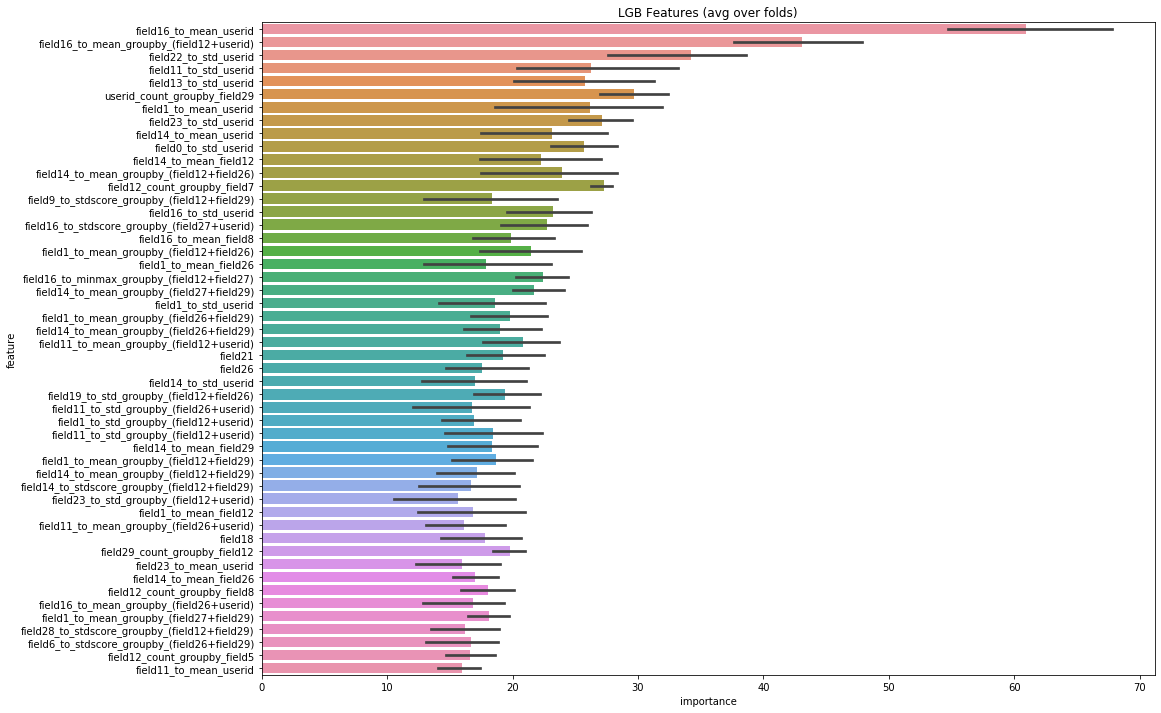

In [72]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

In [73]:
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
test['proba'] = result_dict['prediction']
sub = pd.read_csv('data/onetwotrip_challenge_sub1.csv')
sub['proba'] = test['proba'] / test['proba'].max()
sub.reset_index(drop=True).set_index('orderid').to_csv(f'{p.working_folder}/submission-{t}.csv')

## Goal2

In [19]:
exclude_features_from_training = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23',
       'goal24', 'goal25', 'goal1','userid',]

In [21]:
sub2 = pd.read_csv('data/onetwotrip_challenge_sub2.csv')

In [40]:
sub2.columns = ['orderid', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']
sub2 = pd.DataFrame(0, columns=sub2.columns, index=sub2.index)

Goal  1
Fold 1 started at Tue Dec 17 16:18:17 2019
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.875224	training's auc: 0.875224	valid_1's auc: 0.701886	valid_1's auc: 0.701886
[200]	training's auc: 0.925883	training's auc: 0.925883	valid_1's auc: 0.696779	valid_1's auc: 0.696779
Early stopping, best iteration is:
[100]	training's auc: 0.875224	training's auc: 0.875224	valid_1's auc: 0.701886	valid_1's auc: 0.701886
Fold 2 started at Tue Dec 17 16:19:23 2019
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.876093	training's auc: 0.876093	valid_1's auc: 0.693512	valid_1's auc: 0.693512
Early stopping, best iteration is:
[30]	training's auc: 0.792081	training's auc: 0.792081	valid_1's auc: 0.700029	valid_1's auc: 0.700029
Fold 3 started at Tue Dec 17 16:20:16 2019
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.879044	training's auc: 0.879044	valid_1's auc: 0.704456	valid_1'

Early stopping, best iteration is:
[20]	training's auc: 0.941855	training's auc: 0.941858	valid_1's auc: 0.906676	valid_1's auc: 0.906645
Fold 4 started at Tue Dec 17 16:38:07 2019
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.981925	training's auc: 0.981925	valid_1's auc: 0.894457	valid_1's auc: 0.894457
[200]	training's auc: 0.993774	training's auc: 0.993774	valid_1's auc: 0.893544	valid_1's auc: 0.893544
Early stopping, best iteration is:
[113]	training's auc: 0.984797	training's auc: 0.984797	valid_1's auc: 0.894875	valid_1's auc: 0.894875
Fold 5 started at Tue Dec 17 16:38:56 2019
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.982665	training's auc: 0.982665	valid_1's auc: 0.897471	valid_1's auc: 0.897471
Early stopping, best iteration is:
[58]	training's auc: 0.969519	training's auc: 0.969519	valid_1's auc: 0.898072	valid_1's auc: 0.898072
CV mean score: 0.9016, std: 0.0060.


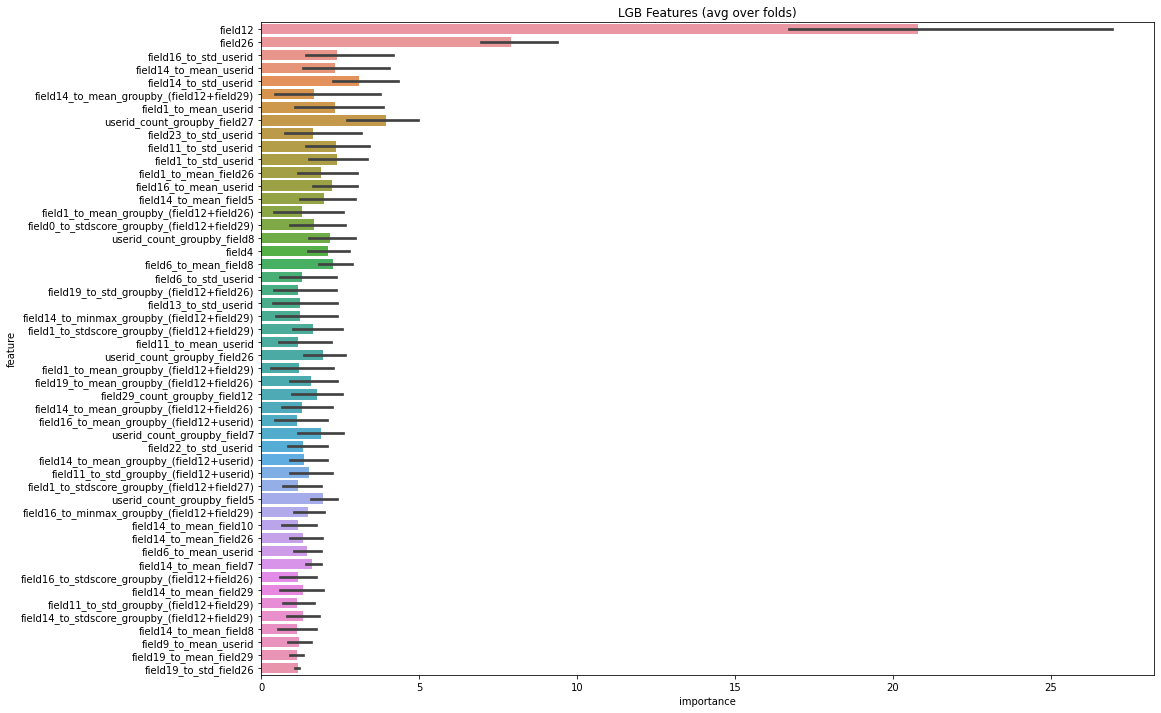

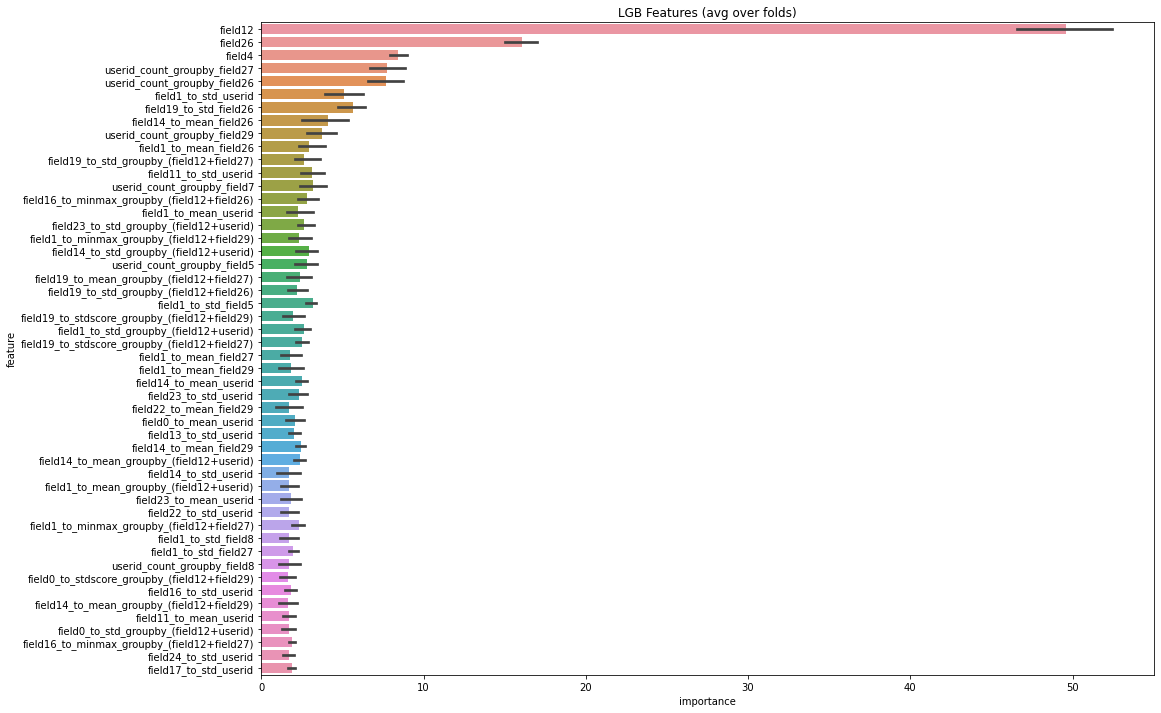

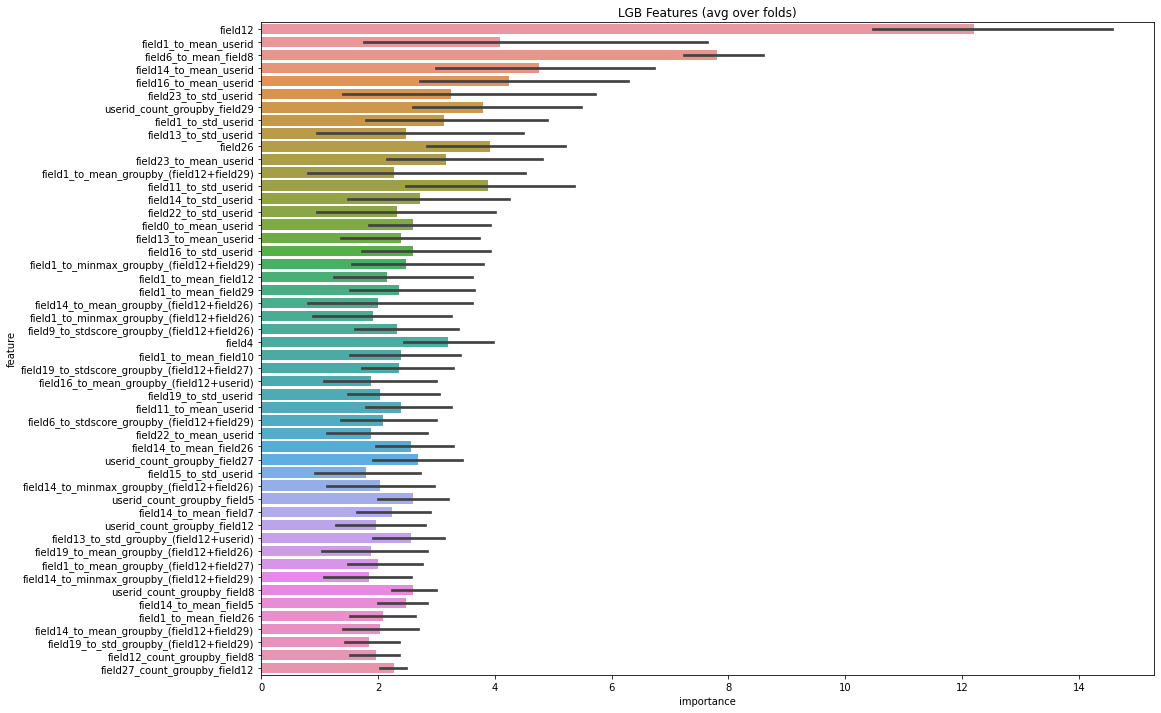

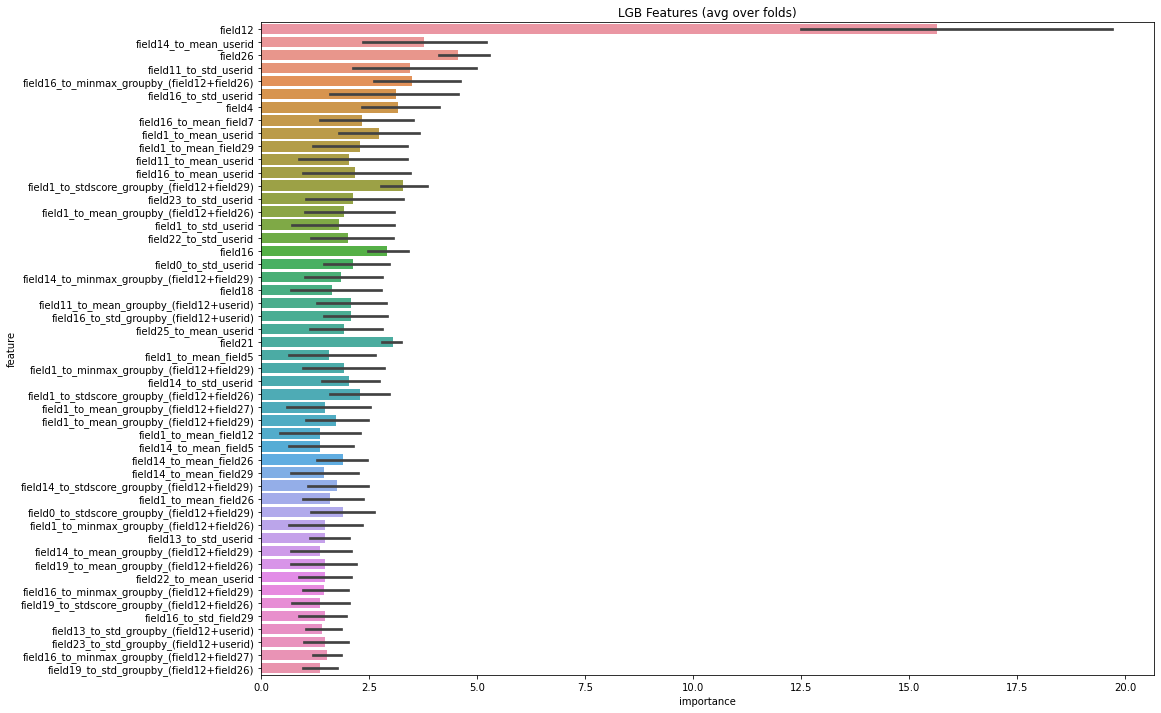

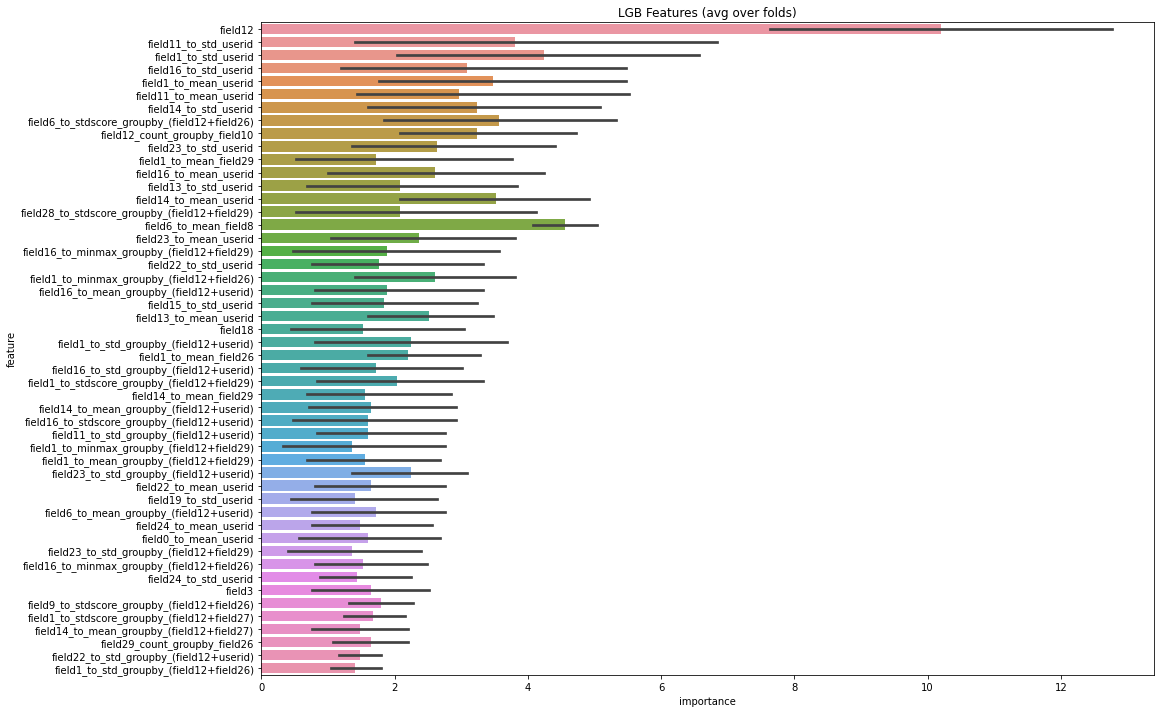

In [41]:
from sklearn.model_selection import GroupKFold, KFold

data = p.data['data']
for i_goal in range(1,6):
    print ("Goal ", i_goal)
    data_filtered = data[data[f'indicator_goal2{i_goal}'] == 1]
    X = data_filtered[data_filtered[f'goal2{i_goal}']>=0].drop([f'goal2{i_goal}'], axis=1)
    y = data_filtered[data_filtered[f'goal2{i_goal}']>=0][f'goal2{i_goal}']
    test=data[data[f'goal2{i_goal}']<0]
    train_features = [f for f in data.columns if f not in exclude_features_from_training]


    NFOLDS = 5
    folds = GroupKFold(n_splits=NFOLDS)
    params = {
              'objective': 'binary',
              "metric": 'auc',
              "verbosity": -1,
             }
    train_options = {
            "model_type":'lgb',
            "params": params,
            "eval_metric":'auc',
            'early_stopping_rounds': 100,
            'n_estimators': 500,
            'averaging': 'rank',
            'use_groups': False,
            'fold_name': folds.__class__.__name__,
            'n_splits': NFOLDS
        }

    result_dict = train_model_classification_vb( X=X, 
                                                 X_test=test, 
                                                 columns=train_features,
                                                 y=y, 
                                                 params=params, folds=folds,
                                                 model_type=train_options['model_type'], 
                                                 plot_feature_importance=True,
                                                 verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                                 n_estimators=train_options['n_estimators'], 
                                                 averaging=train_options['averaging'],
                                                 groups=X['userid'],
                                                 n_jobs=-1)
    test[f'proba2{i_goal}'] = result_dict['prediction']
    sub2[f'goal2{i_goal}'] = test[f'proba2{i_goal}'] / test[f'proba2{i_goal}'].max()
    
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
sub2.reset_index(drop=True).to_csv(f'{p.working_folder}/submission2-{t}.csv')

In [44]:
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
sub2.drop(['orderid'],axis=1).reset_index(drop=True).to_csv(f'{p.working_folder}/submission2-{t}.csv')

## Results

### NO FE. initial

Fold 1 started at Sun Dec 15 19:17:47 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.8352	training's auc: 0.8352	valid_1's auc: 0.660413	valid_1's auc: 0.660413
Early stopping, best iteration is:
[36]	training's auc: 0.769533	training's auc: 0.769533	valid_1's auc: 0.671052	valid_1's auc: 0.671052
Fold 2 started at Sun Dec 15 19:17:58 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.832962	training's auc: 0.832962	valid_1's auc: 0.708005	valid_1's auc: 0.708005
Early stopping, best iteration is:
[27]	training's auc: 0.742707	training's auc: 0.742708	valid_1's auc: 0.71381	valid_1's auc: 0.713811
Fold 3 started at Sun Dec 15 19:18:06 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.833846	training's auc: 0.833846	valid_1's auc: 0.684287	valid_1's auc: 0.684287
Early stopping, best iteration is:
[28]	training's auc: 0.753781	training's auc: 0.753782	valid_1's

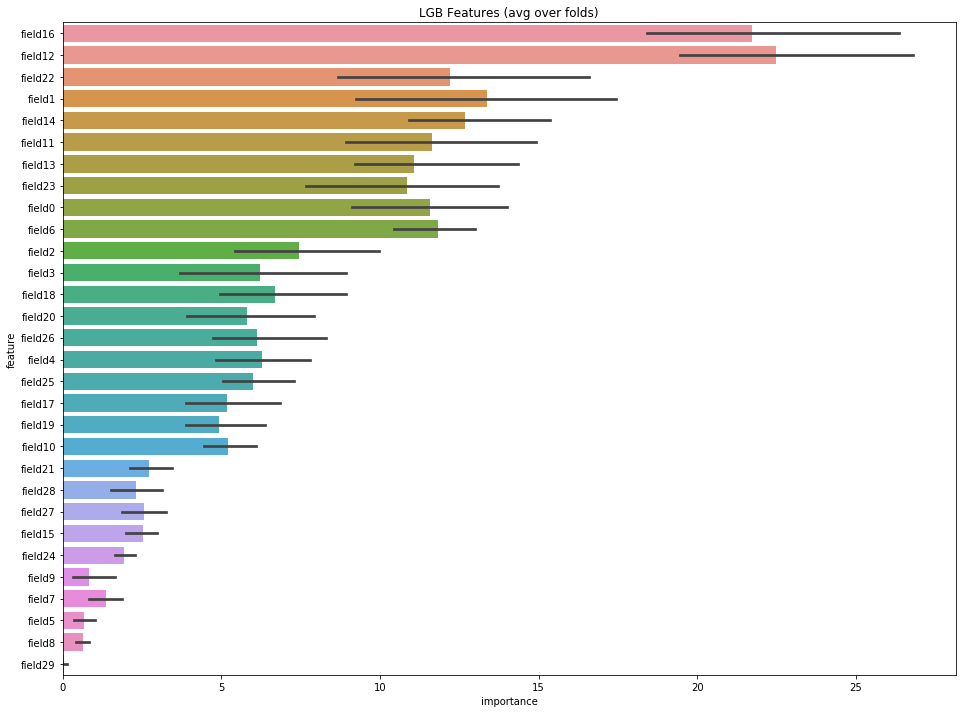

In [22]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### add first aggregate node

Fold 1 started at Sun Dec 15 20:21:06 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.892444	training's auc: 0.892444	valid_1's auc: 0.672213	valid_1's auc: 0.672213
Early stopping, best iteration is:
[67]	training's auc: 0.857729	training's auc: 0.857729	valid_1's auc: 0.676682	valid_1's auc: 0.676682
Fold 2 started at Sun Dec 15 20:21:38 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.890783	training's auc: 0.890783	valid_1's auc: 0.705956	valid_1's auc: 0.705956
Early stopping, best iteration is:
[40]	training's auc: 0.817173	training's auc: 0.817173	valid_1's auc: 0.72028	valid_1's auc: 0.720279
Fold 3 started at Sun Dec 15 20:22:05 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.890927	training's auc: 0.890927	valid_1's auc: 0.688385	valid_1's auc: 0.688385
Early stopping, best iteration is:
[33]	training's auc: 0.803194	training's auc: 0.803194	valid

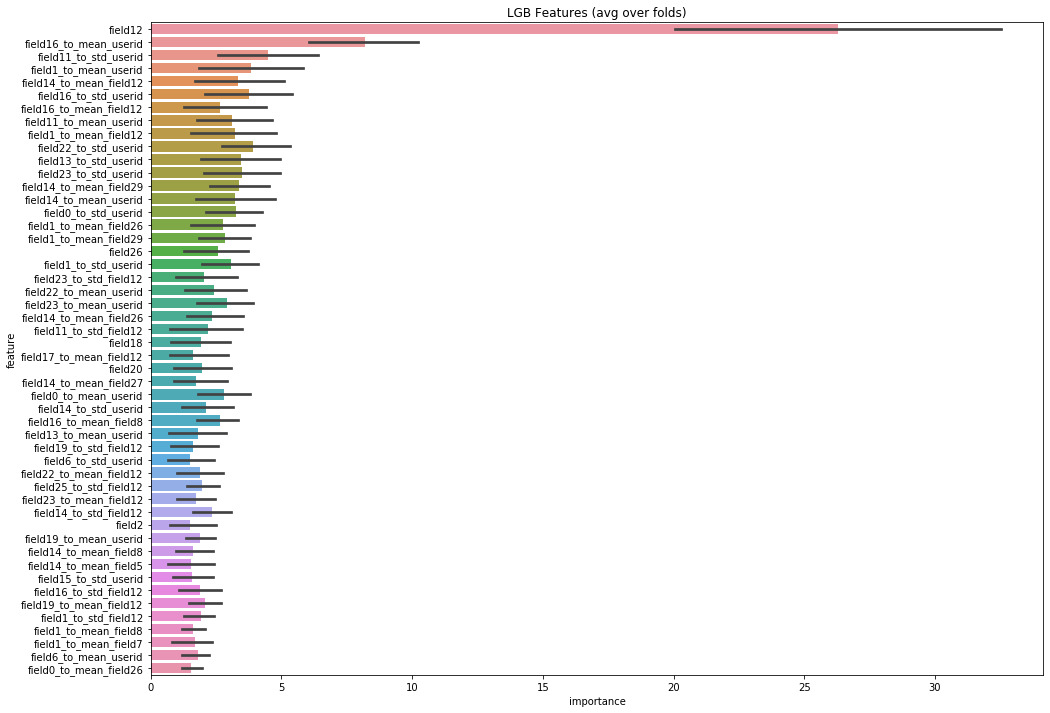

In [13]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### More aggregates

Fold 1 started at Mon Dec 16 23:23:56 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.904606	training's auc: 0.904606	valid_1's auc: 0.671887	valid_1's auc: 0.671887
Early stopping, best iteration is:
[50]	training's auc: 0.847829	training's auc: 0.847829	valid_1's auc: 0.676644	valid_1's auc: 0.676644
Fold 2 started at Mon Dec 16 23:24:55 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.900505	training's auc: 0.900505	valid_1's auc: 0.712615	valid_1's auc: 0.712615
Early stopping, best iteration is:
[34]	training's auc: 0.810291	training's auc: 0.810291	valid_1's auc: 0.718987	valid_1's auc: 0.718985
Fold 3 started at Mon Dec 16 23:25:42 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.900145	training's auc: 0.900145	valid_1's auc: 0.694774	valid_1's auc: 0.694774
Early stopping, best iteration is:
[46]	training's auc: 0.84242	training's auc: 0.84242	valid_

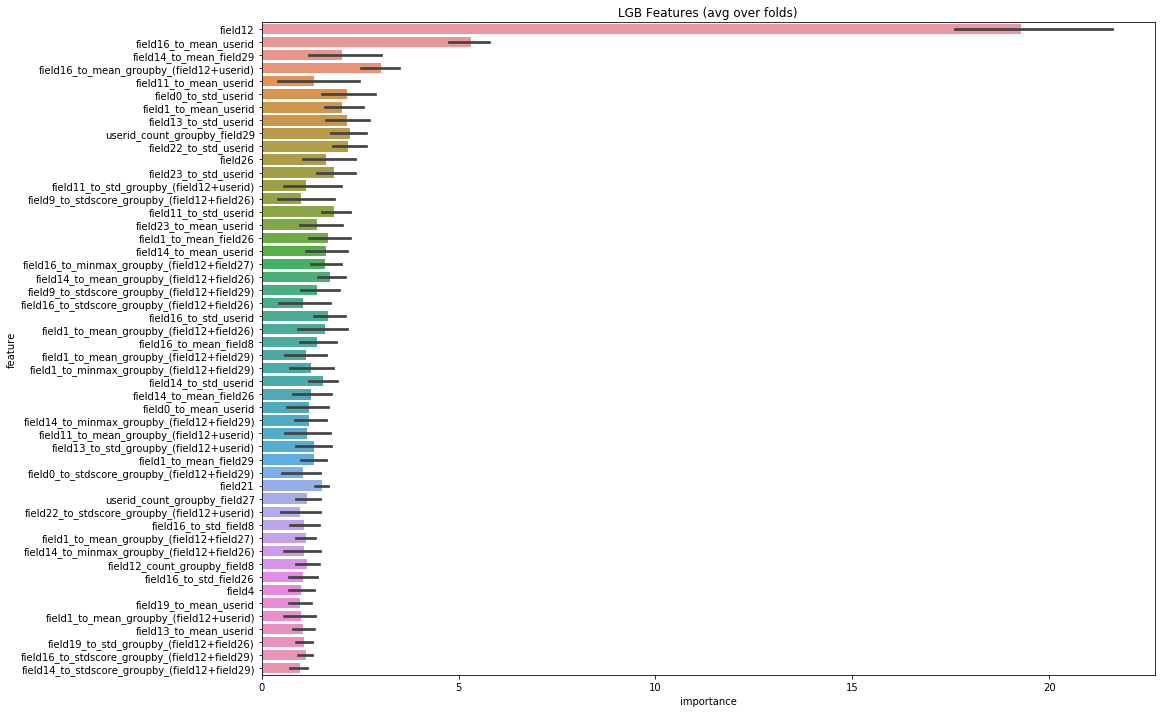

In [15]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### Aggs+rfe+tune params (0.6847) - submission_rfe-12-19-20-54.csv

Fold 1 started at Wed Dec 18 21:29:43 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.784354	training's auc: 0.784353	valid_1's auc: 0.671344	valid_1's auc: 0.671339
[200]	training's auc: 0.828908	training's auc: 0.828908	valid_1's auc: 0.676033	valid_1's auc: 0.676032
[300]	training's auc: 0.866599	training's auc: 0.866599	valid_1's auc: 0.678715	valid_1's auc: 0.678715
[400]	training's auc: 0.894881	training's auc: 0.894881	valid_1's auc: 0.679986	valid_1's auc: 0.679986
[500]	training's auc: 0.91094	training's auc: 0.91094	valid_1's auc: 0.67955	valid_1's auc: 0.67955
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.91094	training's auc: 0.91094	valid_1's auc: 0.67955	valid_1's auc: 0.67955
Fold 2 started at Wed Dec 18 21:32:46 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.771693	training's auc: 0.771689	valid_1's auc: 0.712078	valid_1's auc: 0.71208
[200]	training's auc:

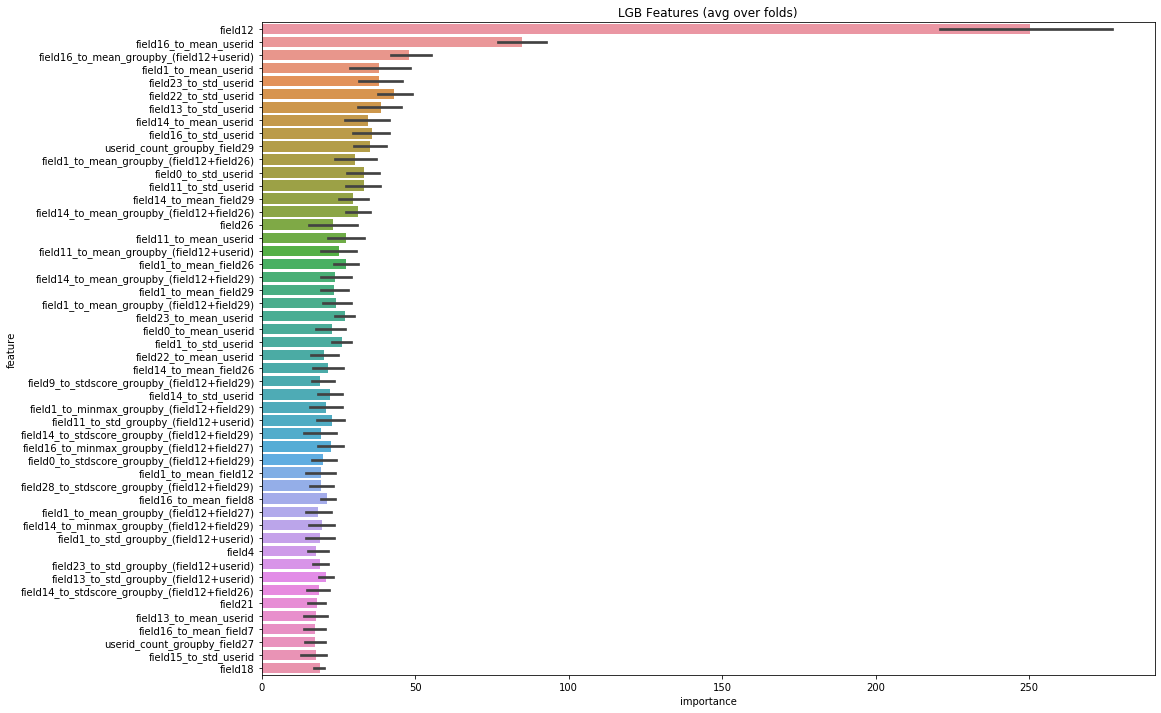

In [19]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)